In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import torch.distributions as D
import hamiltorch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
def make_empirical_predictive(weights, x_input, y_output):
    pred_list, _ = hamiltorch.predict_model(net, x = x_input.flatten().to(device),
                                                  y = y_output.flatten().to(device), samples=weights,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)
    
    # need to make gmm at each sample
    return pred_list

def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

def compute_gmm_lp(weights, x, y):
    preds = make_empirical_predictive(weights, x, y)
    
    gmm = make_empirical_gmm(preds)
    
    return gmm.log_prob(y.squeeze()).sum()

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
from models.BNNs.DeterministicNN import Deterministic_NN

In [8]:
def plot_preds(weights, ax=None, title='',
               plt_train_kwargs={'alpha' : 1, 'marker' :'*', 'color':'k', 'rasterized' : True},
               plt_test_kwargs={'alpha' : 0.5, 'marker' :'+', 'color':'k', 'rasterized' : True},
               plt_mean_kwargs={'color':'b', 'rasterized' : True},
               plt_true_kwargs={'color':'r', 'rasterized' : True},
               epistemic_kwargs={'alpha' : 0.5, 'rasterized' : True},
               aleatoric_kwargs={'alpha' : 0.2, 'rasterized' : True},
               fs=16,
               ):
    preds = make_empirical_predictive(weights, xs, ys)
    
    test_ll = compute_gmm_lp(weights, x_test, y_test)
    train_ll = compute_gmm_lp(weights, x_data, y_data)
    if ax is None:
        ax = plt.gca()

    m = preds.mean(0).to('cpu')
    s = preds.std(0).to('cpu')
    s_al = (preds.var(0).to('cpu') + tau_out ** -1) ** 0.5

    # Get upper and lower confidence bounds
    lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
    # + aleotoric
    lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

    # Plot training data as black stars
    ax.scatter(x_data.numpy(), y_data.numpy(), **plt_train_kwargs, label='Train Data')
#     # Plot testing data as black crosses
#     ax.scatter(x_test.numpy(), y_test.numpy(), **plt_test_kwargs, label='Test Data')
    # Plot predictive means as blue line
    ax.plot(xs.numpy(), m.numpy(), **plt_mean_kwargs, label='Mean')
    ax.plot(xs.numpy(), ys.numpy(), **plt_true_kwargs, label='Ground Truth')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), **epistemic_kwargs, label='Epistemic')
    ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), **aleatoric_kwargs, label = 'Aleatoric')
    #ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_title(title, fontsize=fs)
    ax.set_xlim(-10., 10.)
    bbox = {'facecolor': 'white', 'alpha': 0.6, 'pad': 0.5, 'boxstyle': 'round', 'edgecolor':'black'}
    ax.text(-5, 1.2, f'Test LL: {test_ll:.2f}', bbox=bbox, fontsize=fs, horizontalalignment='center')
    ax.text(-5, 0.05, f'Train LL: {train_ll:.2f}', bbox=bbox, fontsize=fs, horizontalalignment='center')
    ax.grid()
    return(ax)

In [9]:
# create toy dataset
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(20)
x = torch.cat([torch.Tensor(75).uniform_(-5, -2).sort()[0].reshape(-1, 1),
               torch.Tensor(50).uniform_(2, 5).sort()[0].reshape(-1, 1)])
i = 30
x_data = torch.cat([x[0:i - 15], x[i + 14:]])

# generate some data
alpha, beta, num_nodes = 1., 100., 2

# generate some data
data_generator_model = Deterministic_NN(alpha=alpha, beta=beta, num_nodes=num_nodes)
sampled_weights = data_generator_model.sample_weights_from_prior()
data_generator_model.make_weights_from_sample(sampled_weights)
y_data = data_generator_model(x_data).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_data).detach())

x_test = torch.Tensor(200).uniform_(-10., 10.).sort()[0]
y_test = data_generator_model(x_test).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_test).detach()).sort()[0]

xs = torch.linspace(-10, 10, 100)
ys = data_generator_model(xs).detach()

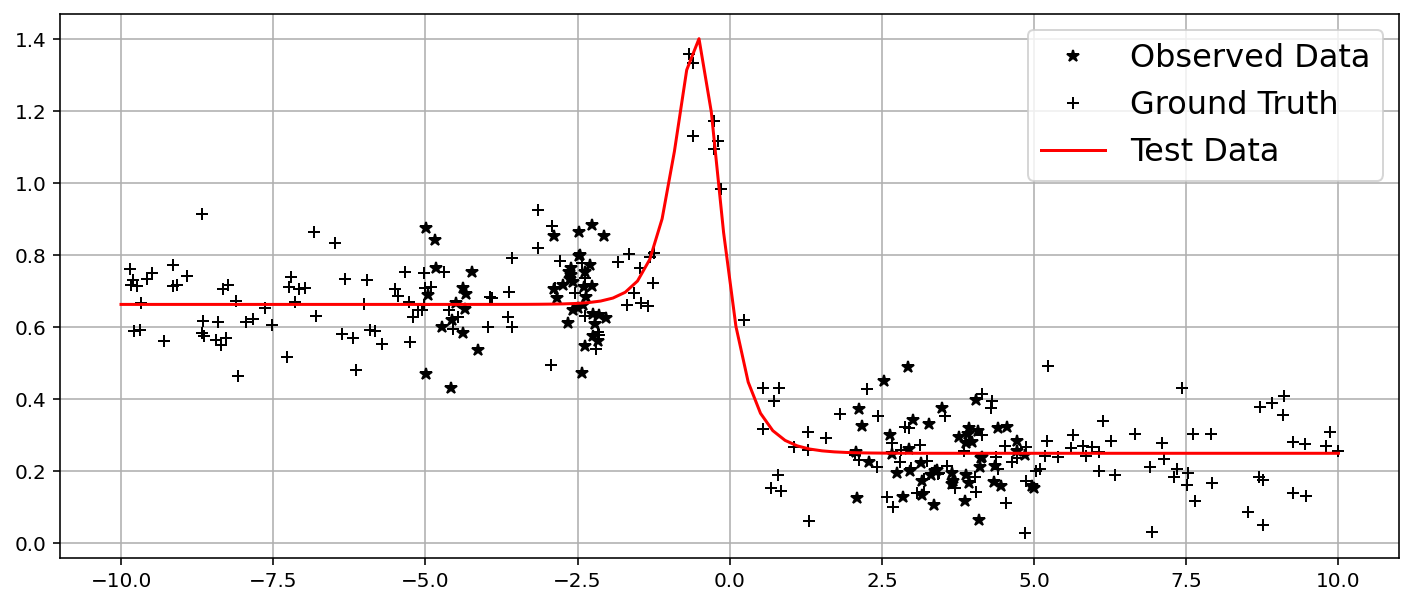

In [10]:
plt.figure(figsize=(12,5))
plt.plot(x_data,y_data, 'k*')
plt.plot(x_test,y_test, 'k+')
plt.plot(xs, ys, 'r')
plt.legend(['Observed Data', 'Ground Truth', 'Test Data'], fontsize = 16)
plt.grid()
plt.show()

In [11]:
device = torch.device('cpu')
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x.view(-1, 1)))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(num_nodes=num_nodes)

In [12]:
# params for plotting 
model_loss = 'regression'
tau = alpha # Prior Precision
tau_out = beta # Output Precision
r = 0 # Random seed


tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

# Emp vs KDE

In [13]:
# load data
true_hmc_weights = pkl.load(open('PickledStuff/BNN_STUFF/HMC_TRUE_WEIGHTS.pkl', 'rb'))
compressed_weights_kde_exact = pkl.load(open('PickledStuff/BNN_STUFF/kde_exact_beta_1_1000.pkl', 'rb'))
compressed_weights_kde_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0.2_1000.pkl', 'rb'))
compressed_weights_emp_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/emp_0_1000.pkl', 'rb'))
compressed_weights_emp_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/emp_0.1_1000.pkl', 'rb'))
compressed_weights_emp_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/emp_0.2_1000.pkl', 'rb'))

In [14]:
weights = [true_hmc_weights, compressed_weights_kde_exact, 
           compressed_weights_kde_low_eps, compressed_weights_emp_low_eps,
           compressed_weights_kde_med_eps, compressed_weights_emp_med_eps,
           compressed_weights_kde_high_eps, compressed_weights_emp_high_eps]

In [15]:
preds = {}
preds['True HMC samples'] = true_hmc_weights
preds['Exact KDE Samples'] = compressed_weights_kde_exact
preds['Compressed EMP, ' + r'$\epsilon=0$'] = compressed_weights_emp_low_eps
preds['Compressed KDE, ' + r'$\epsilon=0$'] = compressed_weights_kde_low_eps
preds['Compressed EMP, ' + r'$\epsilon=0.1$'] = compressed_weights_emp_med_eps
preds['Compressed KDE, ' + r'$\epsilon=0.1$'] = compressed_weights_kde_med_eps
preds['Compressed EMP, ' + r'$\epsilon=0.2$'] = compressed_weights_emp_high_eps
preds['Compressed KDE, ' + r'$\epsilon=0.2$'] = compressed_weights_kde_high_eps

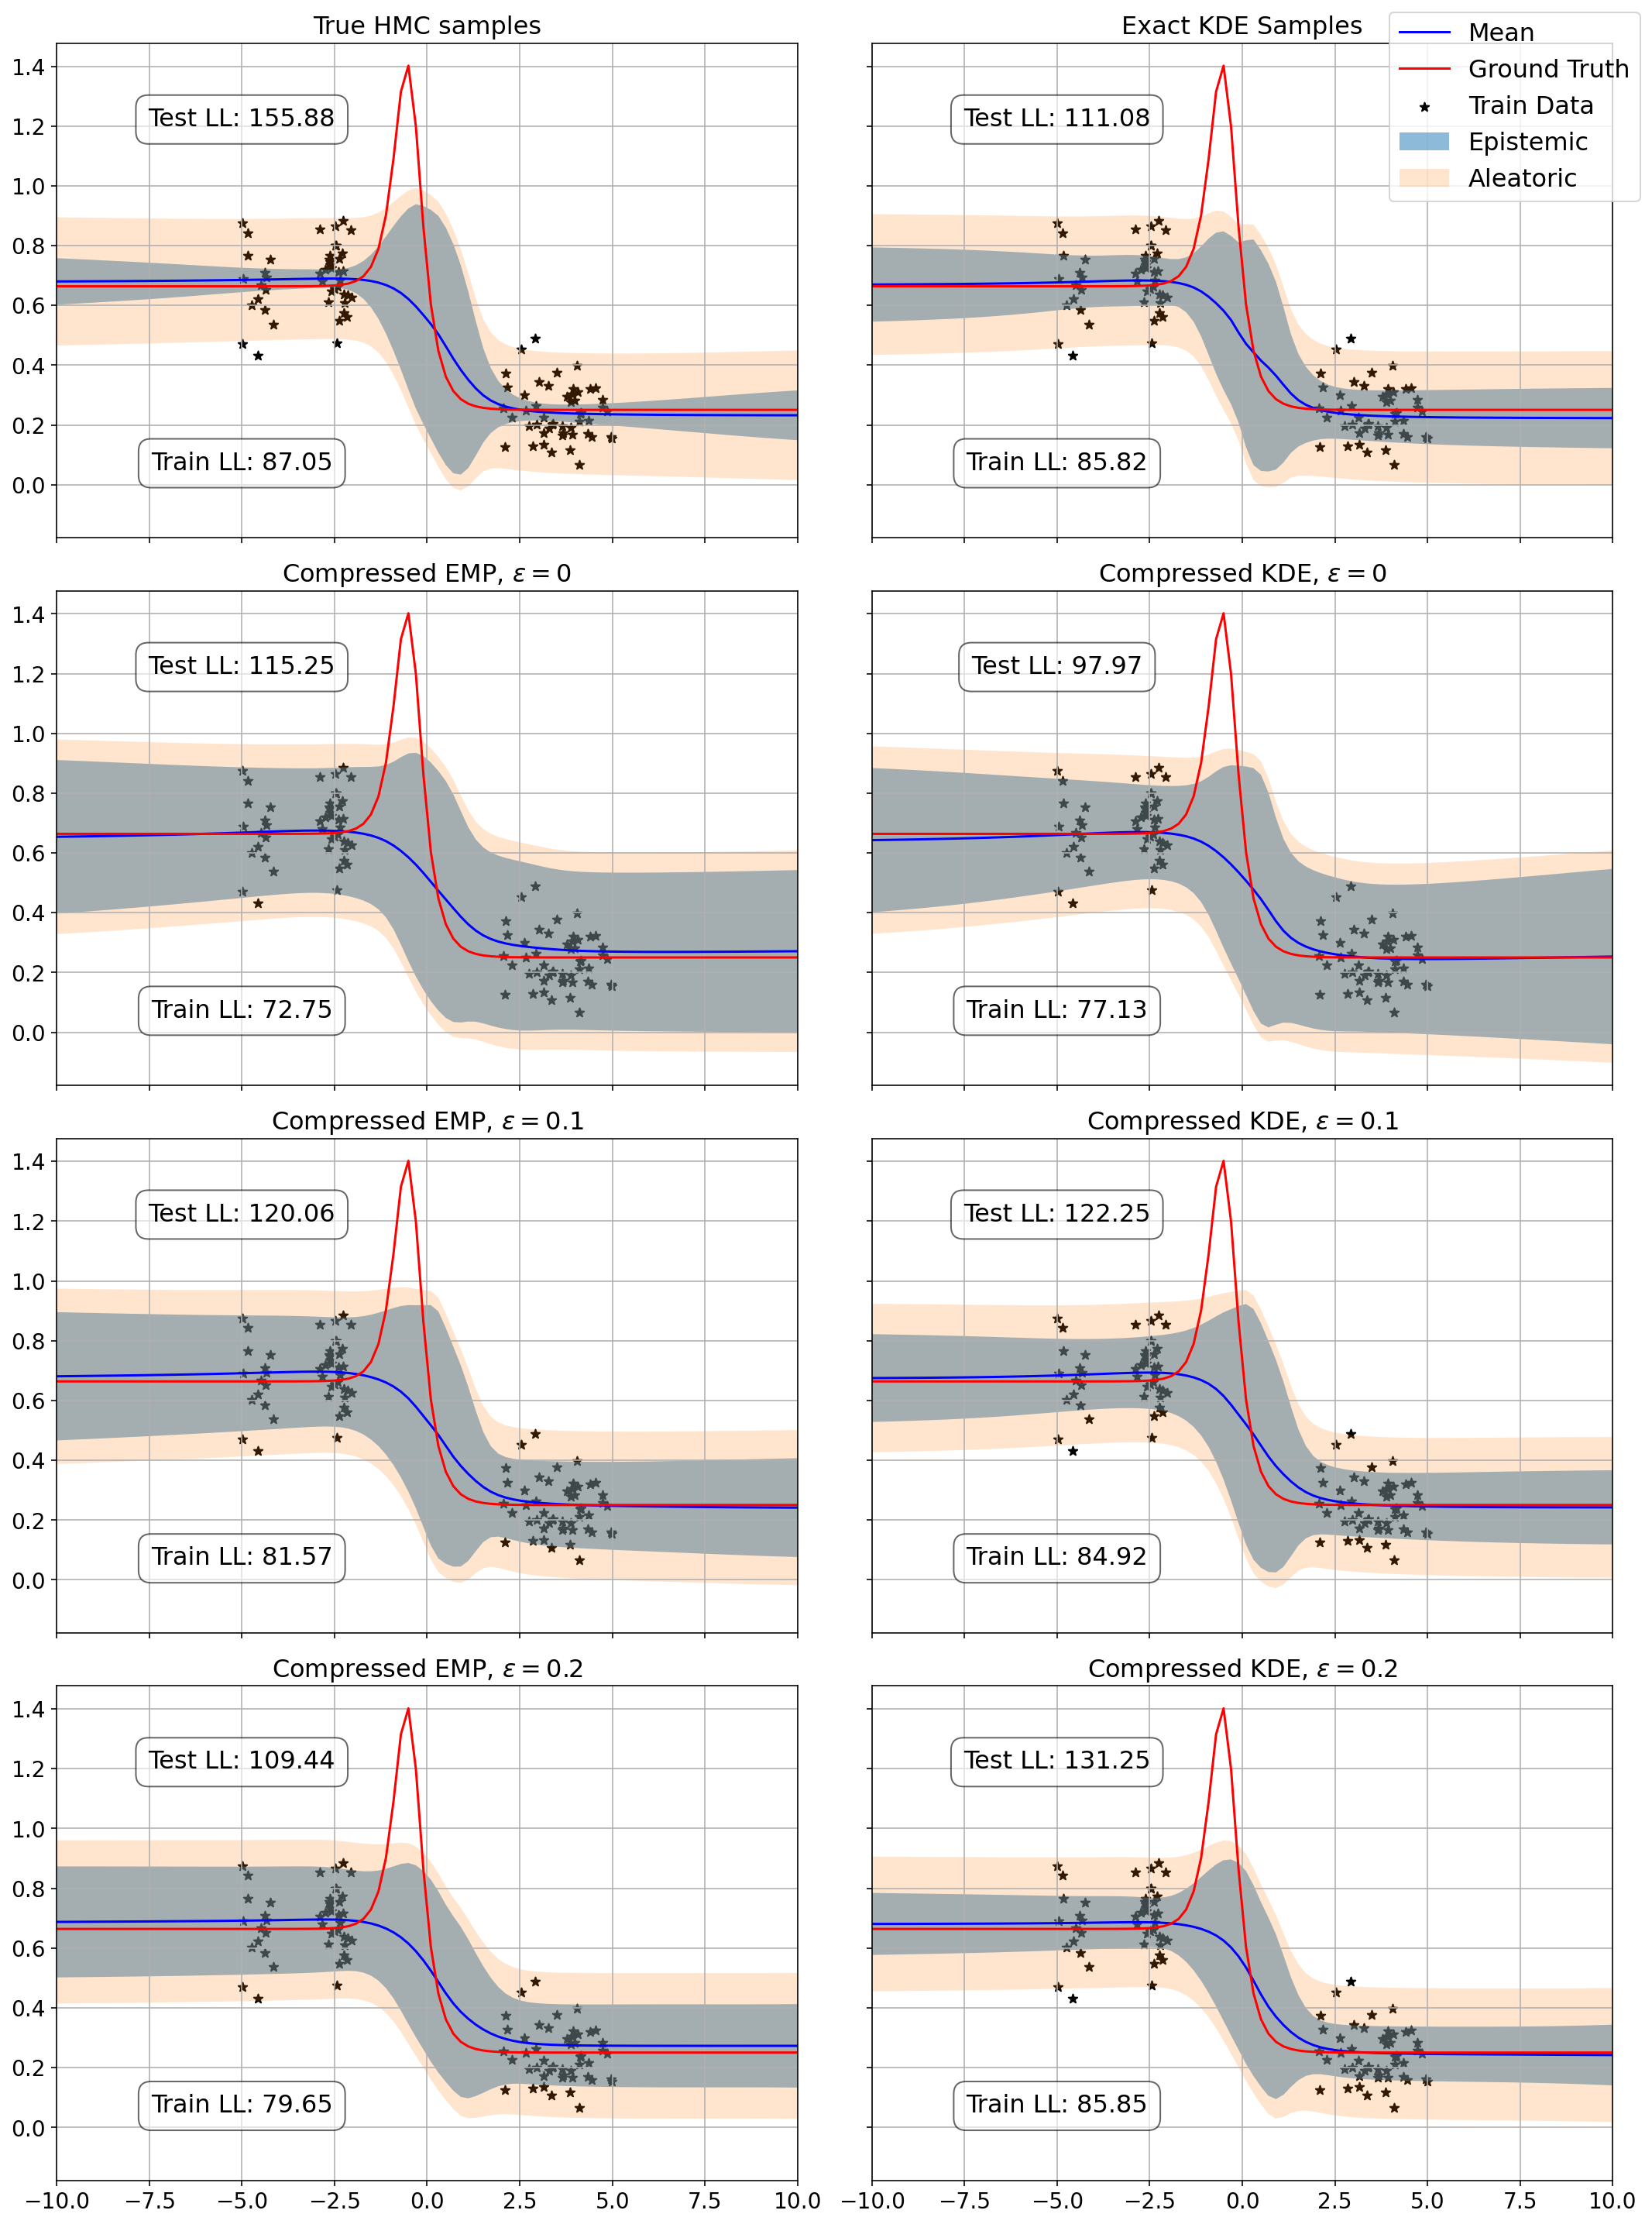

In [16]:
f, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

# beta 1.5

In [17]:
# load data
compressed_weights_kde_exact = pkl.load(open('PickledStuff/BNN_STUFF/kde_exact_beta_1.5_1000.pkl', 'rb'))
compressed_weights_kde_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1.5_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1.5_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1.5_eps_0.2_1000.pkl', 'rb'))

In [18]:
weights = [compressed_weights_kde_exact, compressed_weights_kde_low_eps, compressed_weights_kde_med_eps, compressed_weights_kde_high_eps]

In [19]:
preds = {}
preds['Exact KDE Samples'] = compressed_weights_kde_exact
preds['Compressed, ' + r'$\epsilon=0$'] = compressed_weights_kde_low_eps
preds['Compressed, ' + r'$\epsilon=0.1$'] = compressed_weights_kde_med_eps
preds['Compressed, ' + r'$\epsilon=0.2$'] = compressed_weights_kde_high_eps

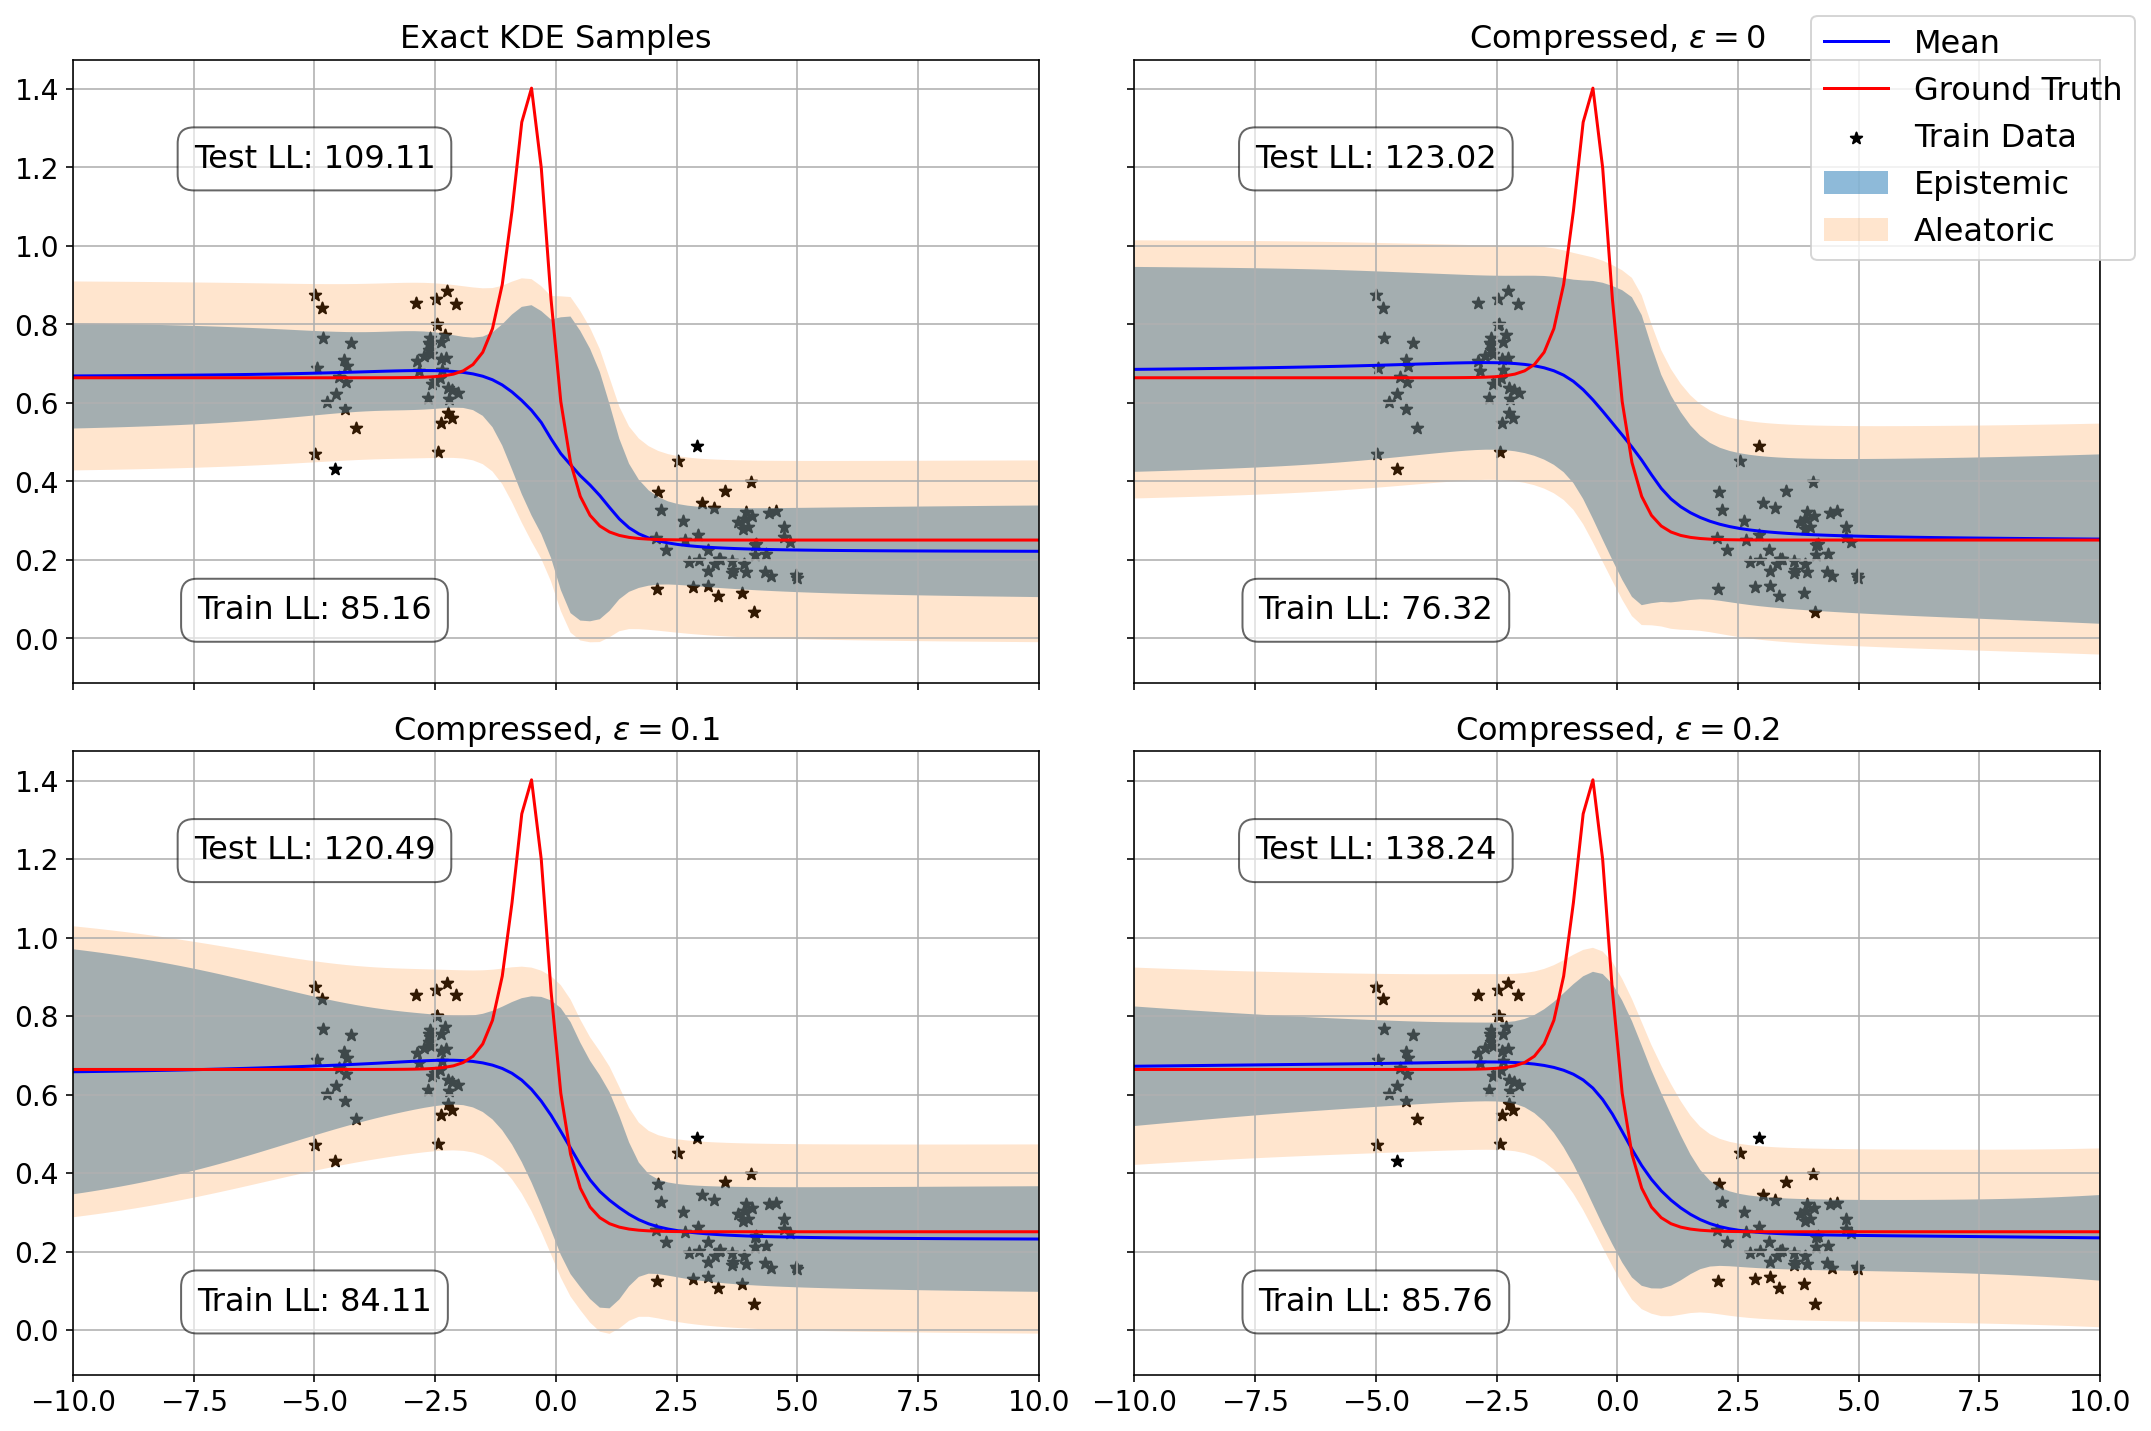

In [20]:
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

# beta 1

In [21]:
# load data
compressed_weights_kde_exact = pkl.load(open('PickledStuff/BNN_STUFF/kde_exact_beta_1_1000.pkl', 'rb'))
compressed_weights_kde_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0.2_1000.pkl', 'rb'))

In [22]:
weights = [compressed_weights_kde_exact, compressed_weights_kde_low_eps, compressed_weights_kde_med_eps, compressed_weights_kde_high_eps]

In [23]:
preds = {}
preds['Exact KDE Samples'] = compressed_weights_kde_exact
preds['Compressed, ' + r'$\epsilon=0$'] = compressed_weights_kde_low_eps
preds['Compressed, ' + r'$\epsilon=0.1$'] = compressed_weights_kde_med_eps
preds['Compressed, ' + r'$\epsilon=0.2$'] = compressed_weights_kde_high_eps

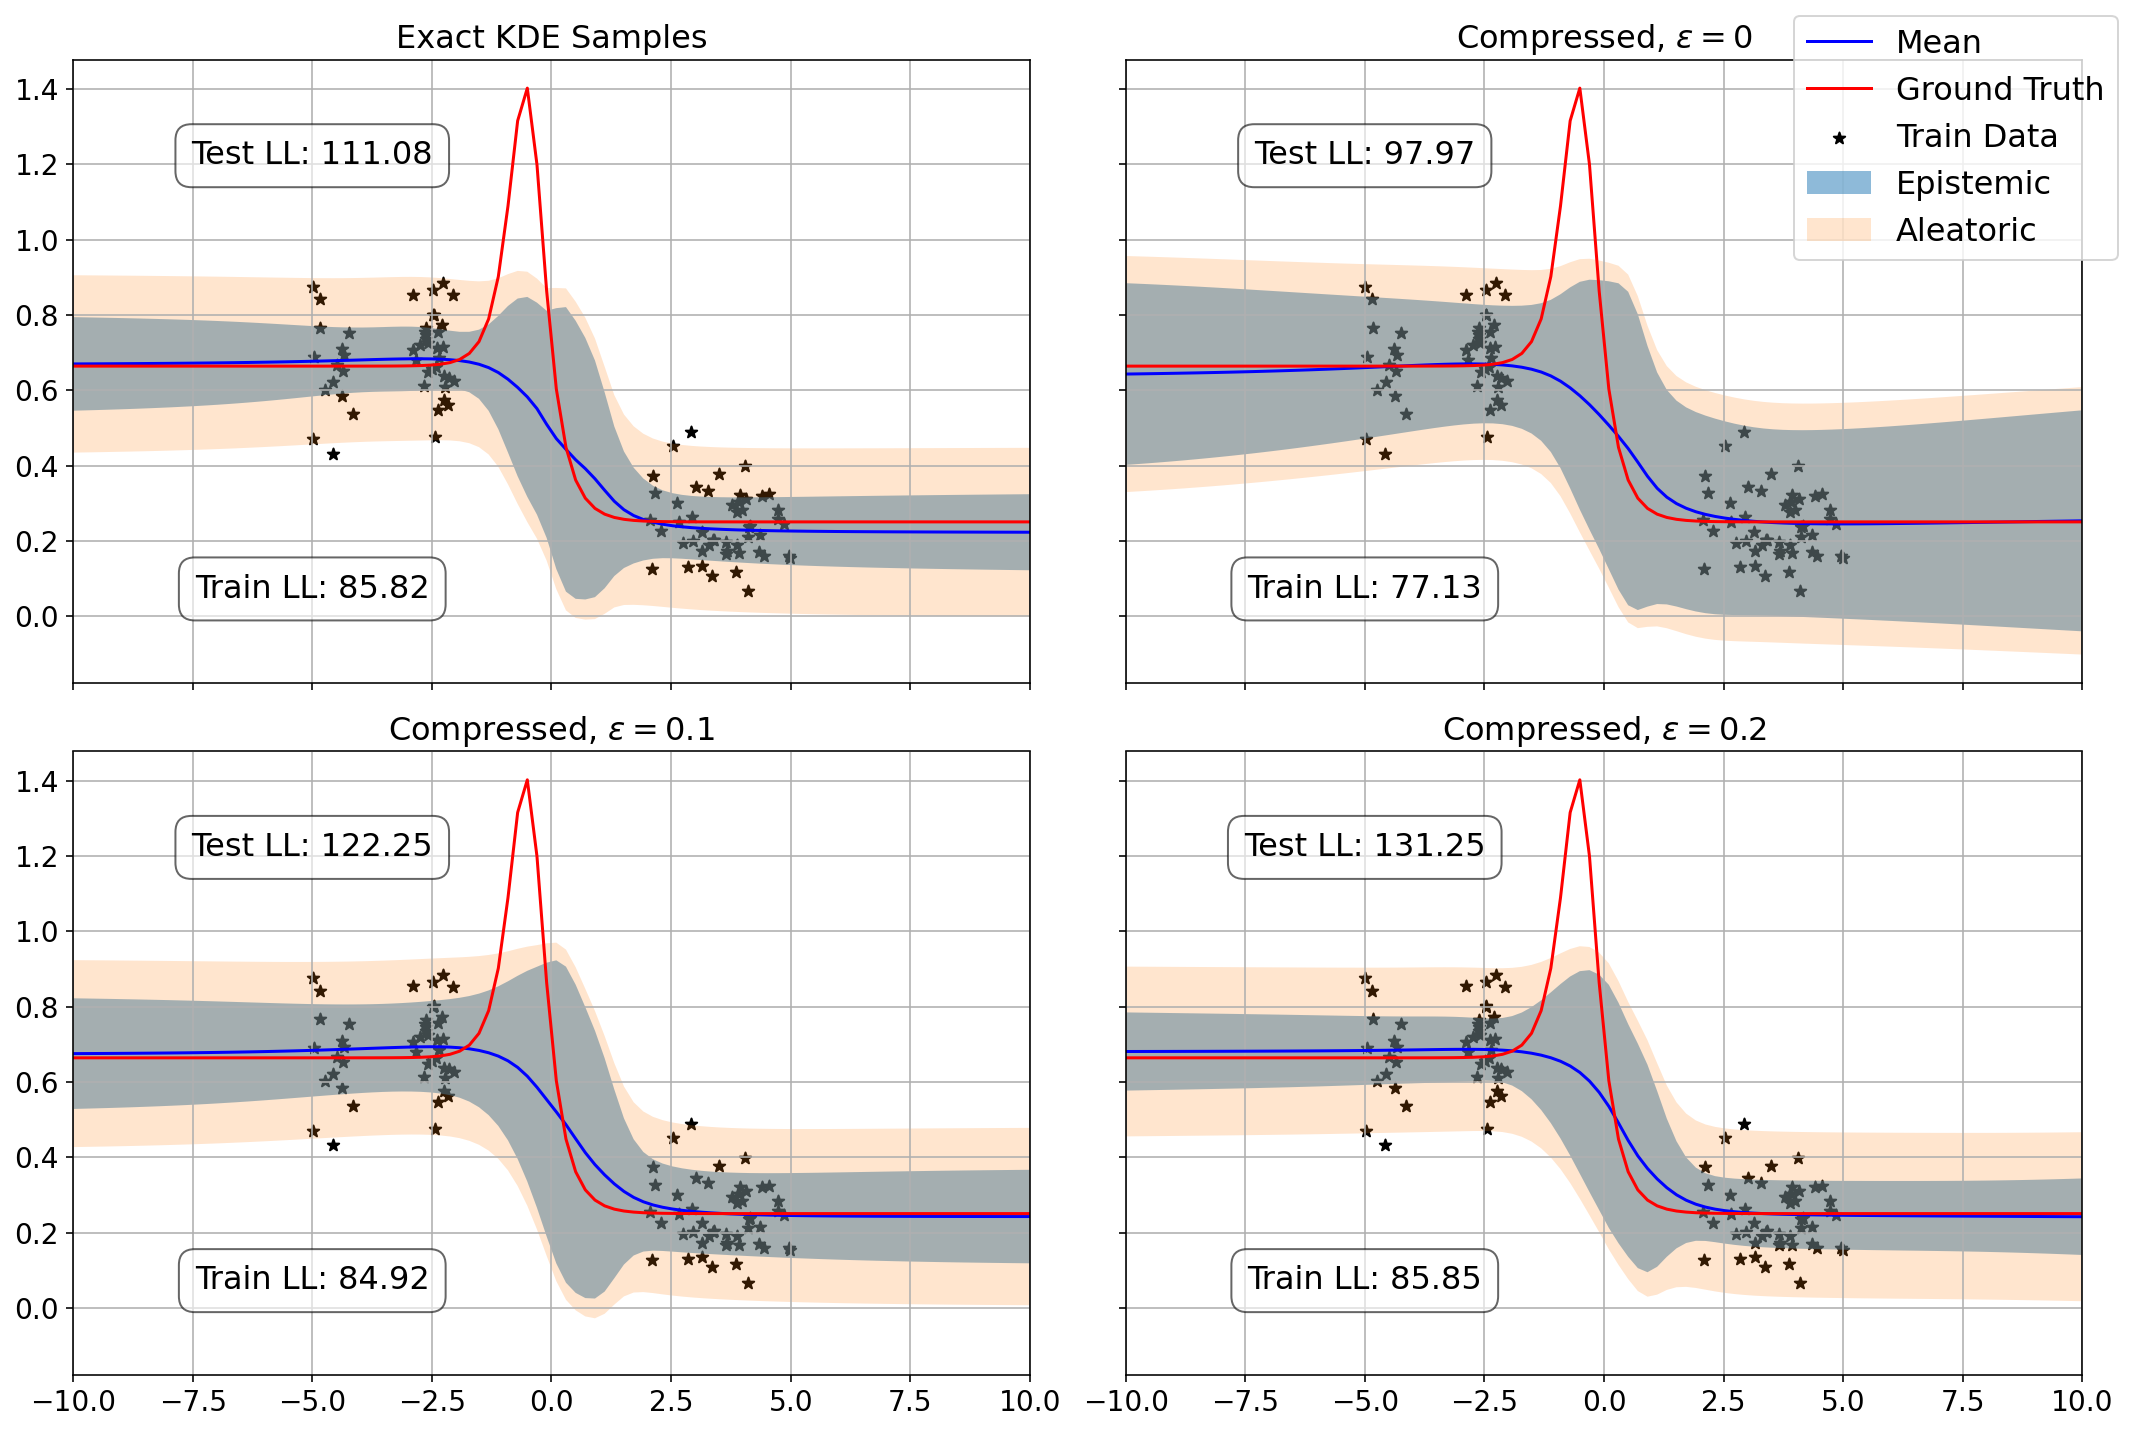

In [24]:
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

# beta 0.75

In [25]:
# load data
compressed_weights_kde_exact = pkl.load(open('PickledStuff/BNN_STUFF/kde_exact_beta_0.75_1000.pkl', 'rb'))
compressed_weights_kde_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.75_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.75_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.75_eps_0.2_1000.pkl', 'rb'))

In [26]:
weights = [compressed_weights_kde_exact, compressed_weights_kde_low_eps, compressed_weights_kde_med_eps, compressed_weights_kde_high_eps]

In [27]:
preds = {}
preds['Exact KDE Samples'] = compressed_weights_kde_exact
preds['Compressed, ' + r'$\epsilon=0$'] = compressed_weights_kde_low_eps
preds['Compressed, ' + r'$\epsilon=0.1$'] = compressed_weights_kde_med_eps
preds['Compressed, ' + r'$\epsilon=0.2$'] = compressed_weights_kde_high_eps

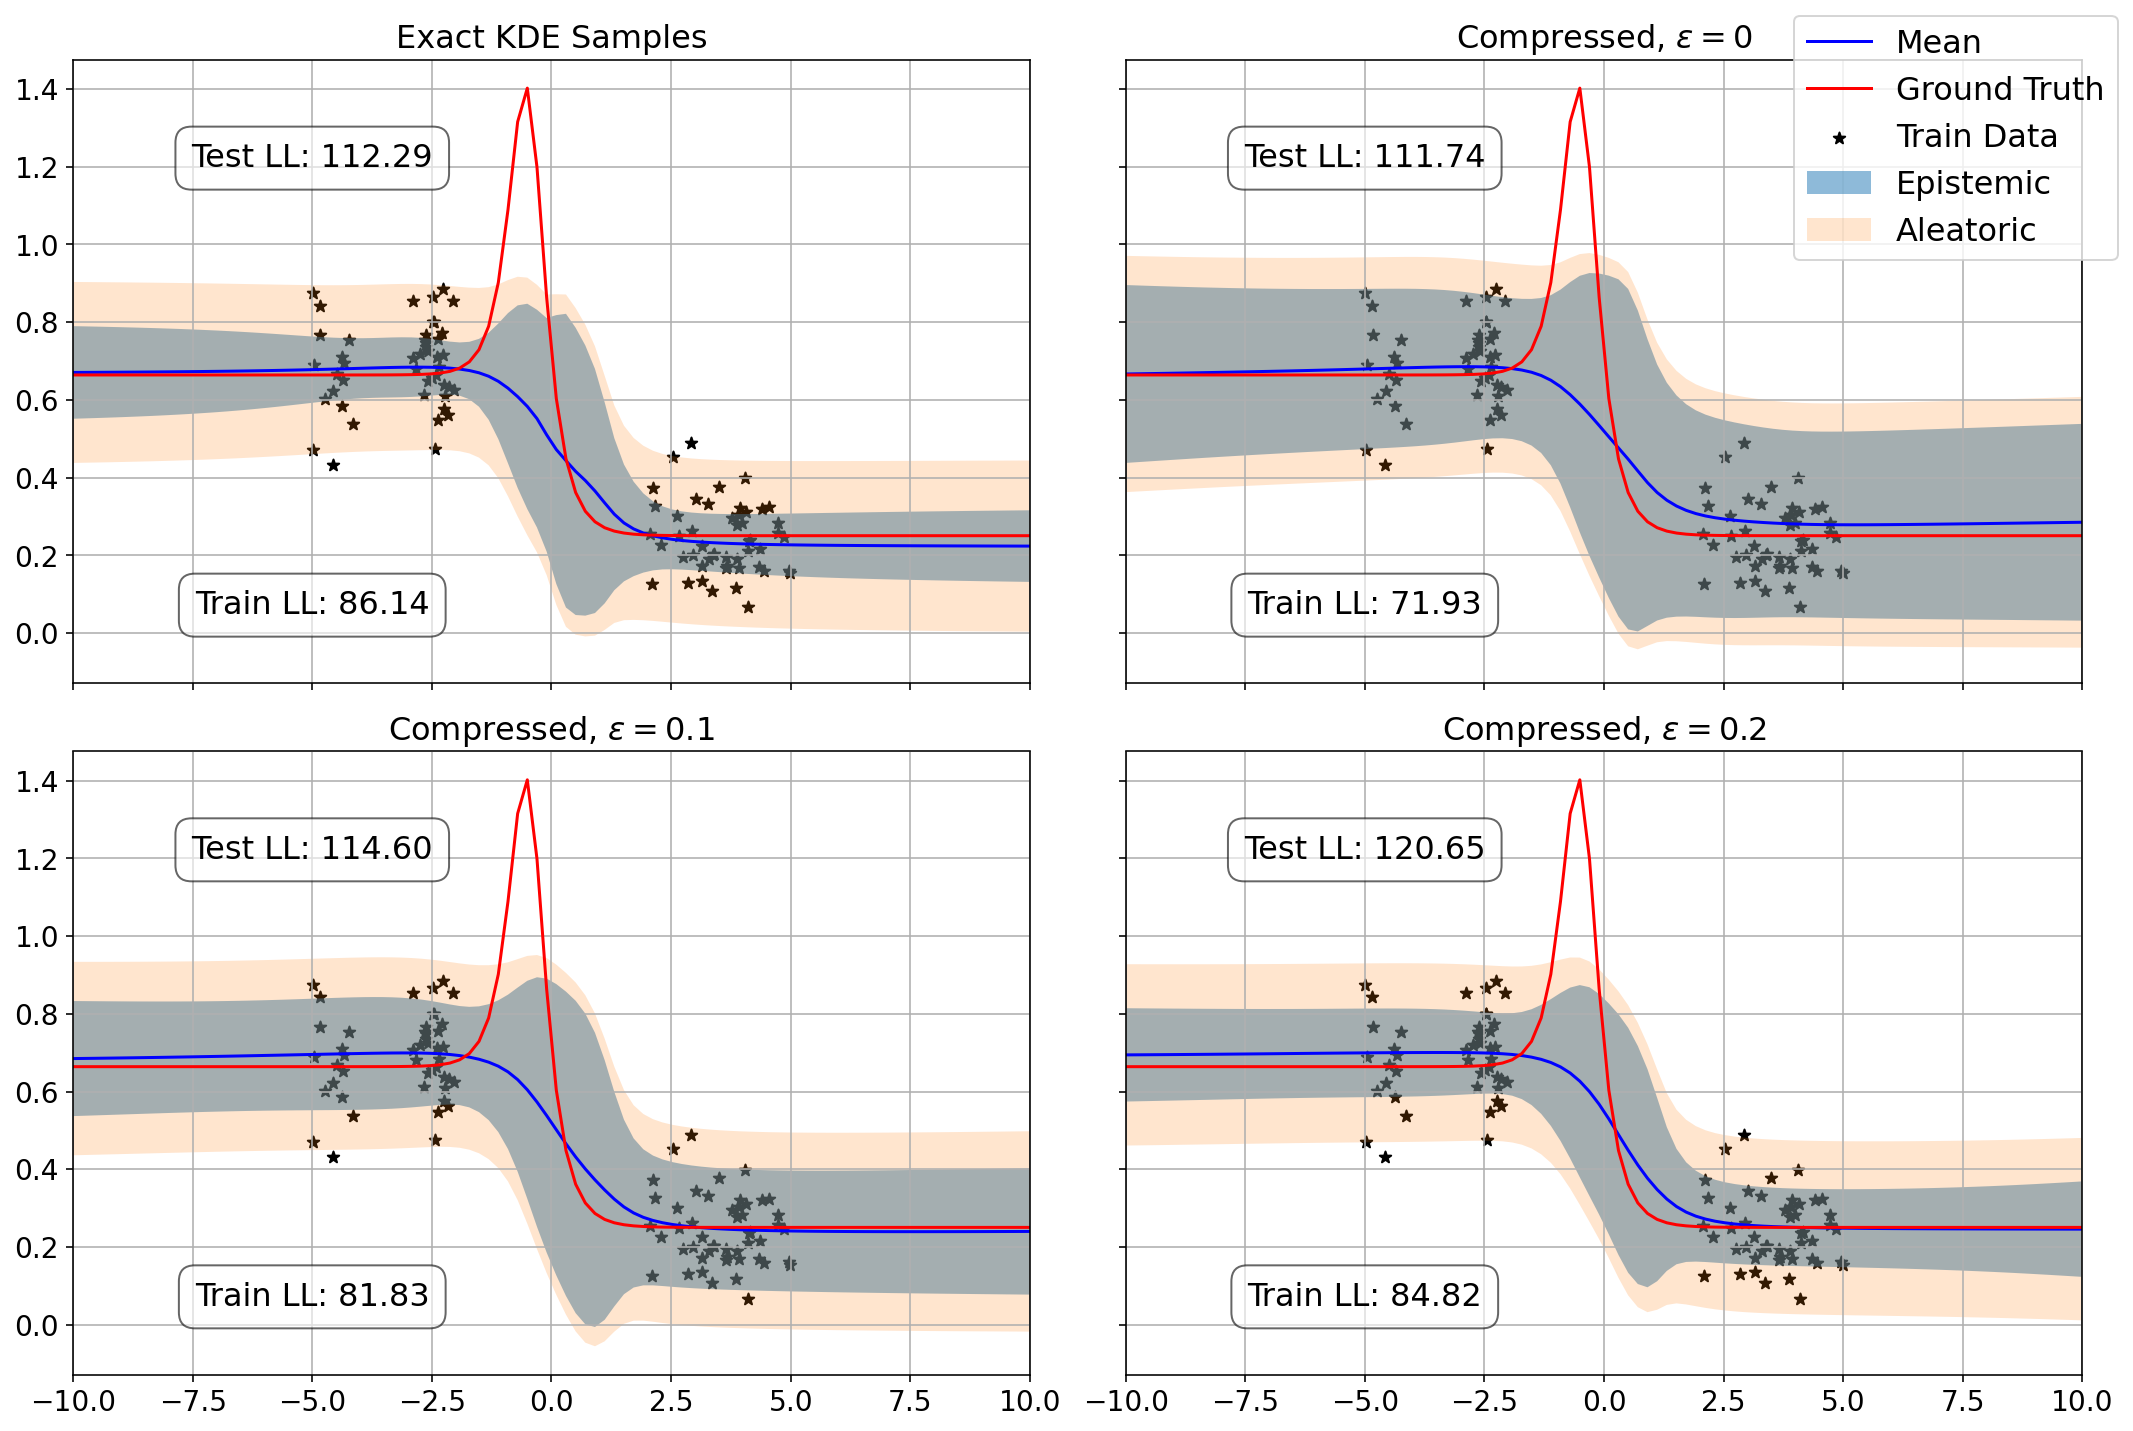

In [28]:
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

# beta 0.5

In [29]:
# load data
compressed_weights_kde_exact = pkl.load(open('PickledStuff/BNN_STUFF/kde_exact_beta_0.5_1000.pkl', 'rb'))
compressed_weights_kde_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.5_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.5_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.5_eps_0.2_1000.pkl', 'rb'))

In [30]:
weights = [compressed_weights_kde_exact, compressed_weights_kde_low_eps, compressed_weights_kde_med_eps, compressed_weights_kde_high_eps]

In [31]:
preds = {}
preds['Exact KDE Samples'] = compressed_weights_kde_exact
preds['Compressed, ' + r'$\epsilon=0$'] = compressed_weights_kde_low_eps
preds['Compressed, ' + r'$\epsilon=0.1$'] = compressed_weights_kde_med_eps
preds['Compressed, ' + r'$\epsilon=0.2$'] = compressed_weights_kde_high_eps

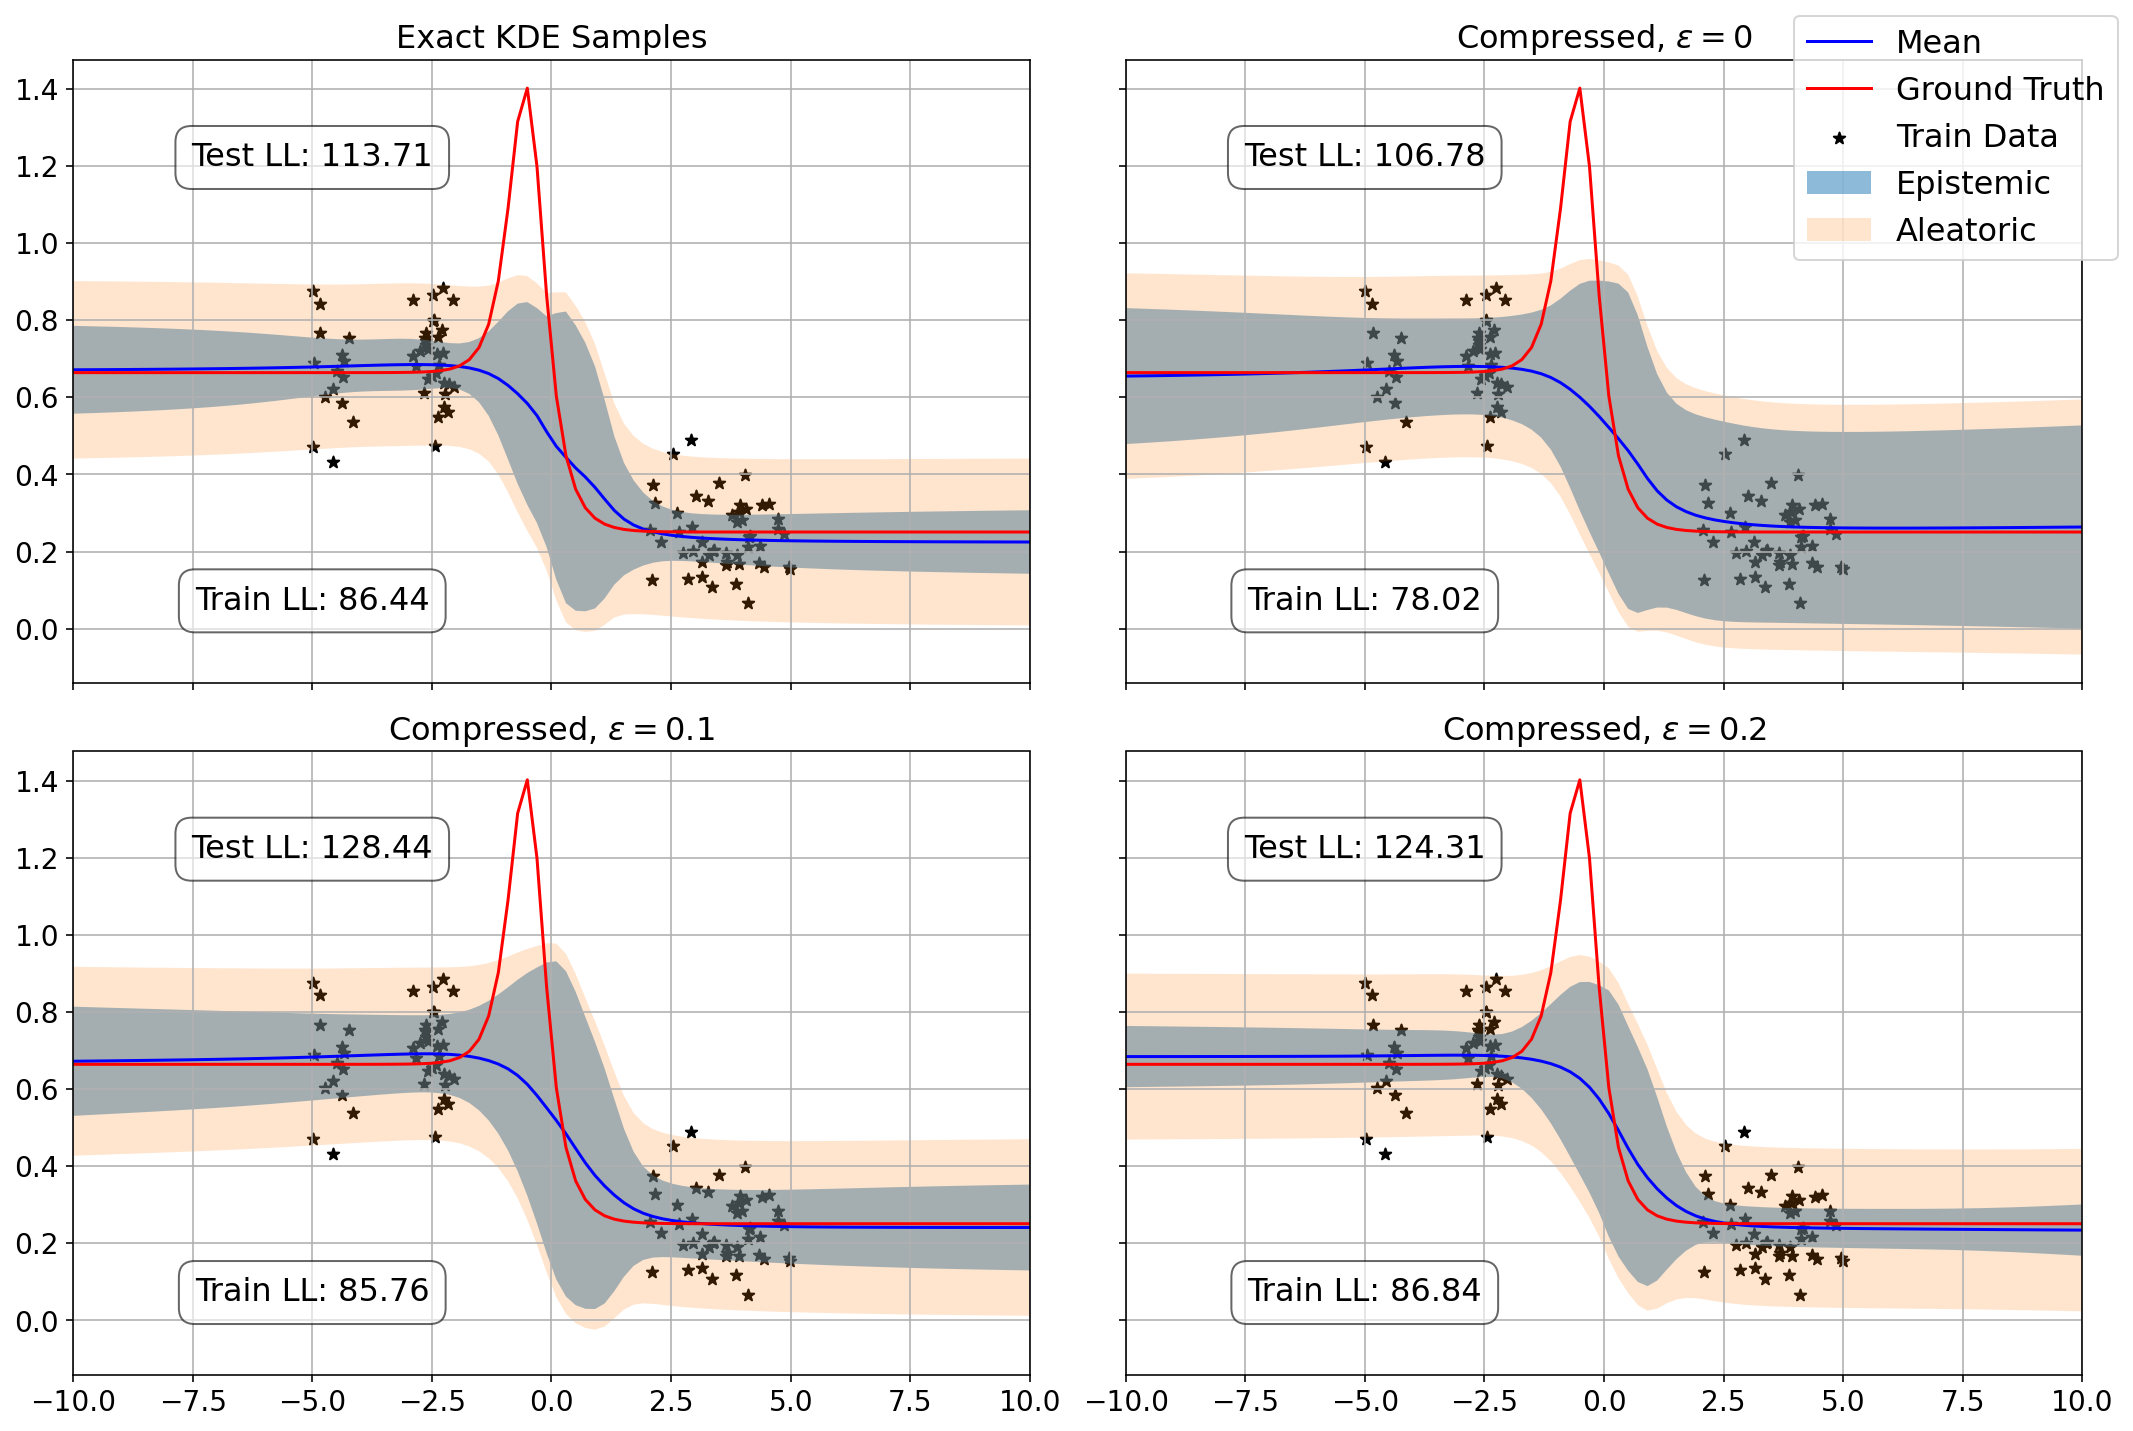

In [32]:
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

# beta 0.25

In [33]:
# load data
compressed_weights_kde_exact = pkl.load(open('PickledStuff/BNN_STUFF/kde_exact_beta_0.25_1000.pkl', 'rb'))
compressed_weights_kde_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.25_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.25_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.25_eps_0.2_1000.pkl', 'rb'))

In [34]:
weights = [compressed_weights_kde_exact, compressed_weights_kde_low_eps, compressed_weights_kde_med_eps, compressed_weights_kde_high_eps]

In [35]:
preds = {}
preds['Exact KDE Samples'] = compressed_weights_kde_exact
preds['Compressed, ' + r'$\epsilon=0$'] = compressed_weights_kde_low_eps
preds['Compressed, ' + r'$\epsilon=0.1$'] = compressed_weights_kde_med_eps
preds['Compressed, ' + r'$\epsilon=0.2$'] = compressed_weights_kde_high_eps

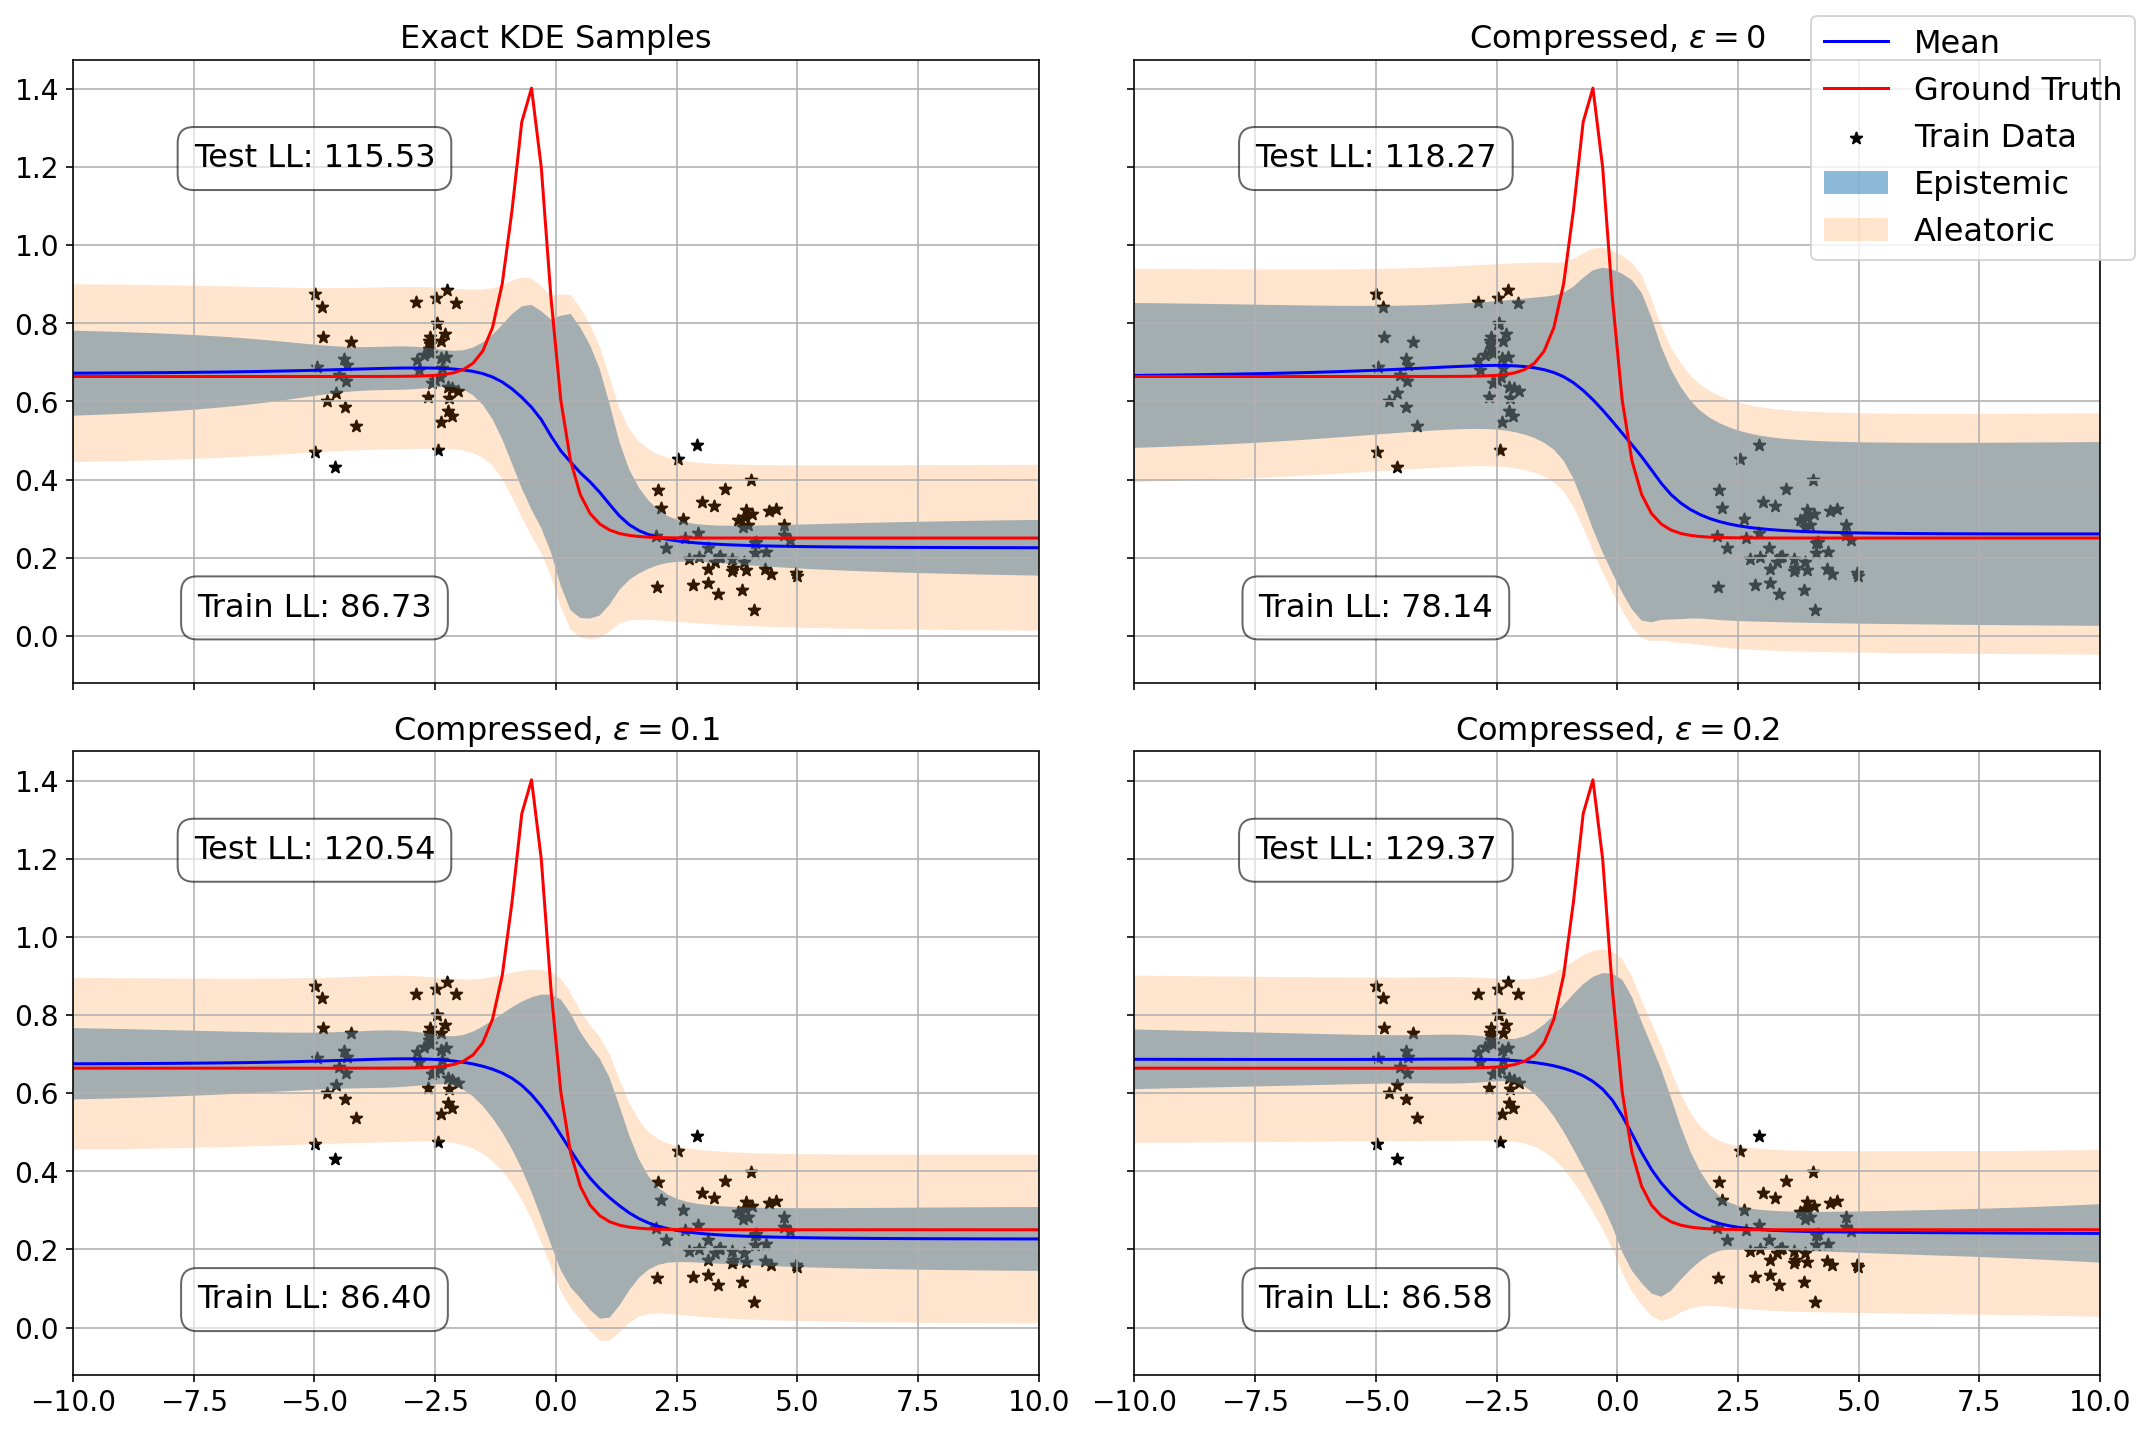

In [36]:
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

# beta 0.1

In [37]:
# load data
compressed_weights_kde_exact = pkl.load(open('PickledStuff/BNN_STUFF/kde_exact_beta_0.1_1000.pkl', 'rb'))
compressed_weights_kde_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.1_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.1_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.1_eps_0.2_1000.pkl', 'rb'))

In [38]:
weights = [compressed_weights_kde_exact, compressed_weights_kde_low_eps, compressed_weights_kde_med_eps, compressed_weights_kde_high_eps]

In [39]:
preds = {}
preds['Exact KDE Samples'] = compressed_weights_kde_exact
preds['Compressed, ' + r'$\epsilon=0$'] = compressed_weights_kde_low_eps
preds['Compressed, ' + r'$\epsilon=0.1$'] = compressed_weights_kde_med_eps
preds['Compressed, ' + r'$\epsilon=0.2$'] = compressed_weights_kde_high_eps

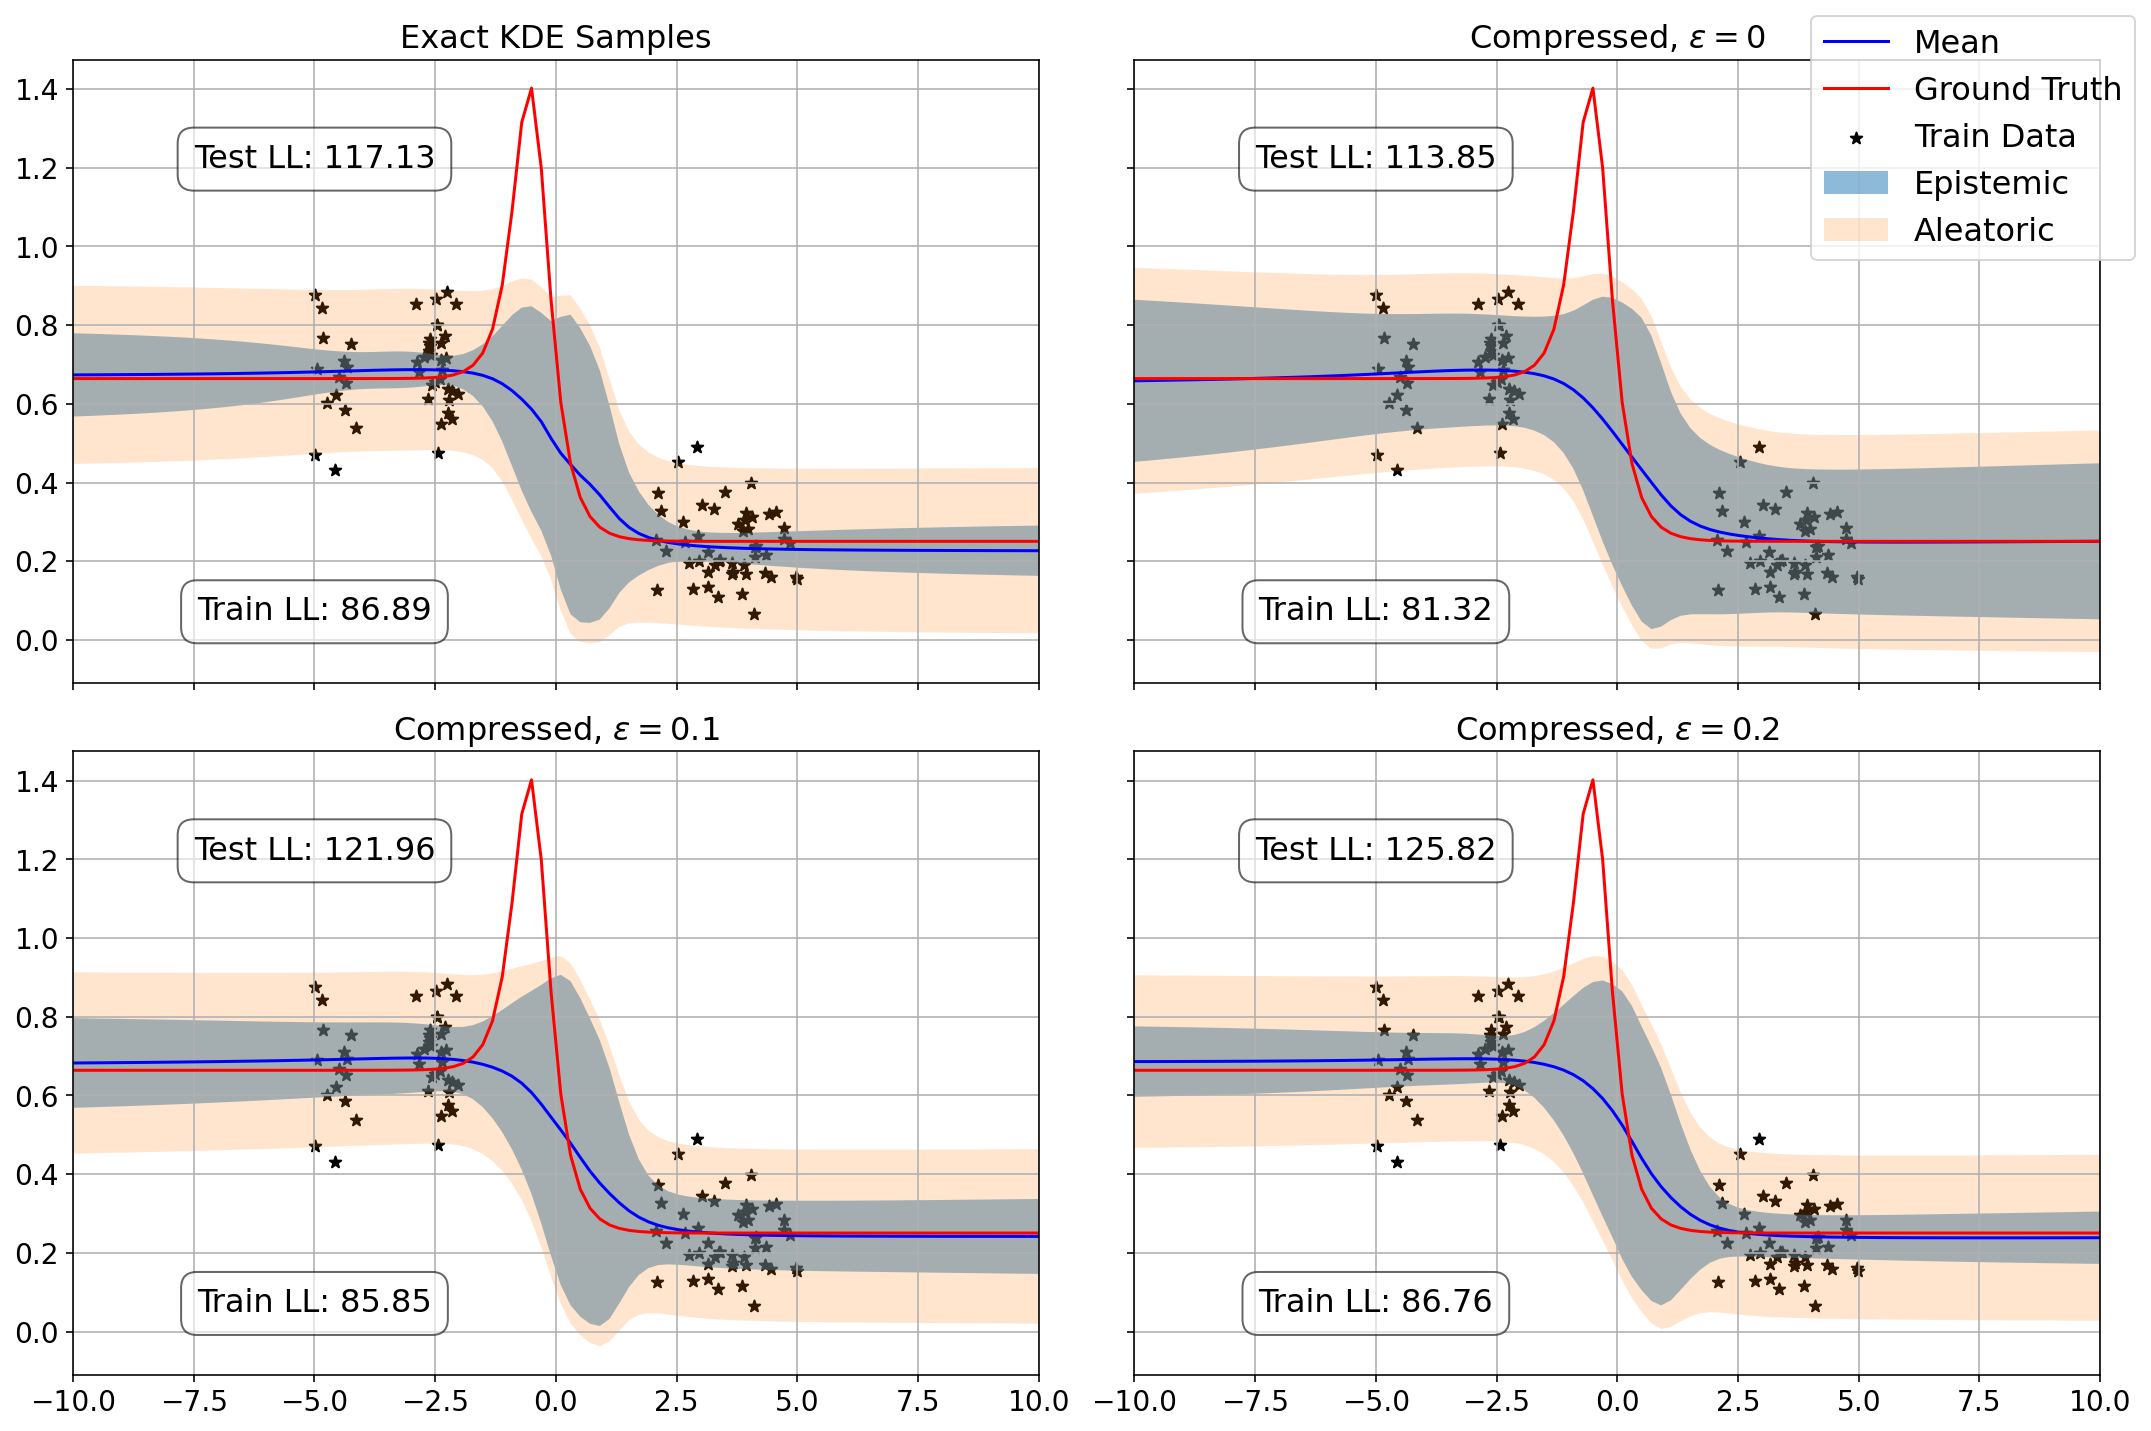

In [40]:
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

# Across Beta Comparisons

## Epsilon = 0

In [41]:
# load data
compressed_weights_kde_beta_1_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1.5_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_beta_1 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_7_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.75_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.5_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_2_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.25_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_1 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.1_eps_0_1000.pkl', 'rb'))

In [42]:
weights = [true_hmc_weights, compressed_weights_kde_beta_1_5, compressed_weights_kde_beta_1, 
           compressed_weights_kde_beta_0_7_5, compressed_weights_kde_beta_0_5,
           compressed_weights_kde_beta_0_2_5, compressed_weights_kde_beta_0_1]

In [43]:
preds = {}
preds['True HMC Samples'] = true_hmc_weights
preds[r'$\beta = 1.5$'] = compressed_weights_kde_beta_1_5
preds[r'$\beta = 1$'] = compressed_weights_kde_beta_1
preds[r'$\beta = 0.75$'] = compressed_weights_kde_beta_0_7_5
preds[r'$\beta = 0.5$'] = compressed_weights_kde_beta_0_5
preds[r'$\beta = 0.25$'] = compressed_weights_kde_beta_0_2_5
preds[r'$\beta = 0.1$'] = compressed_weights_kde_beta_0_1

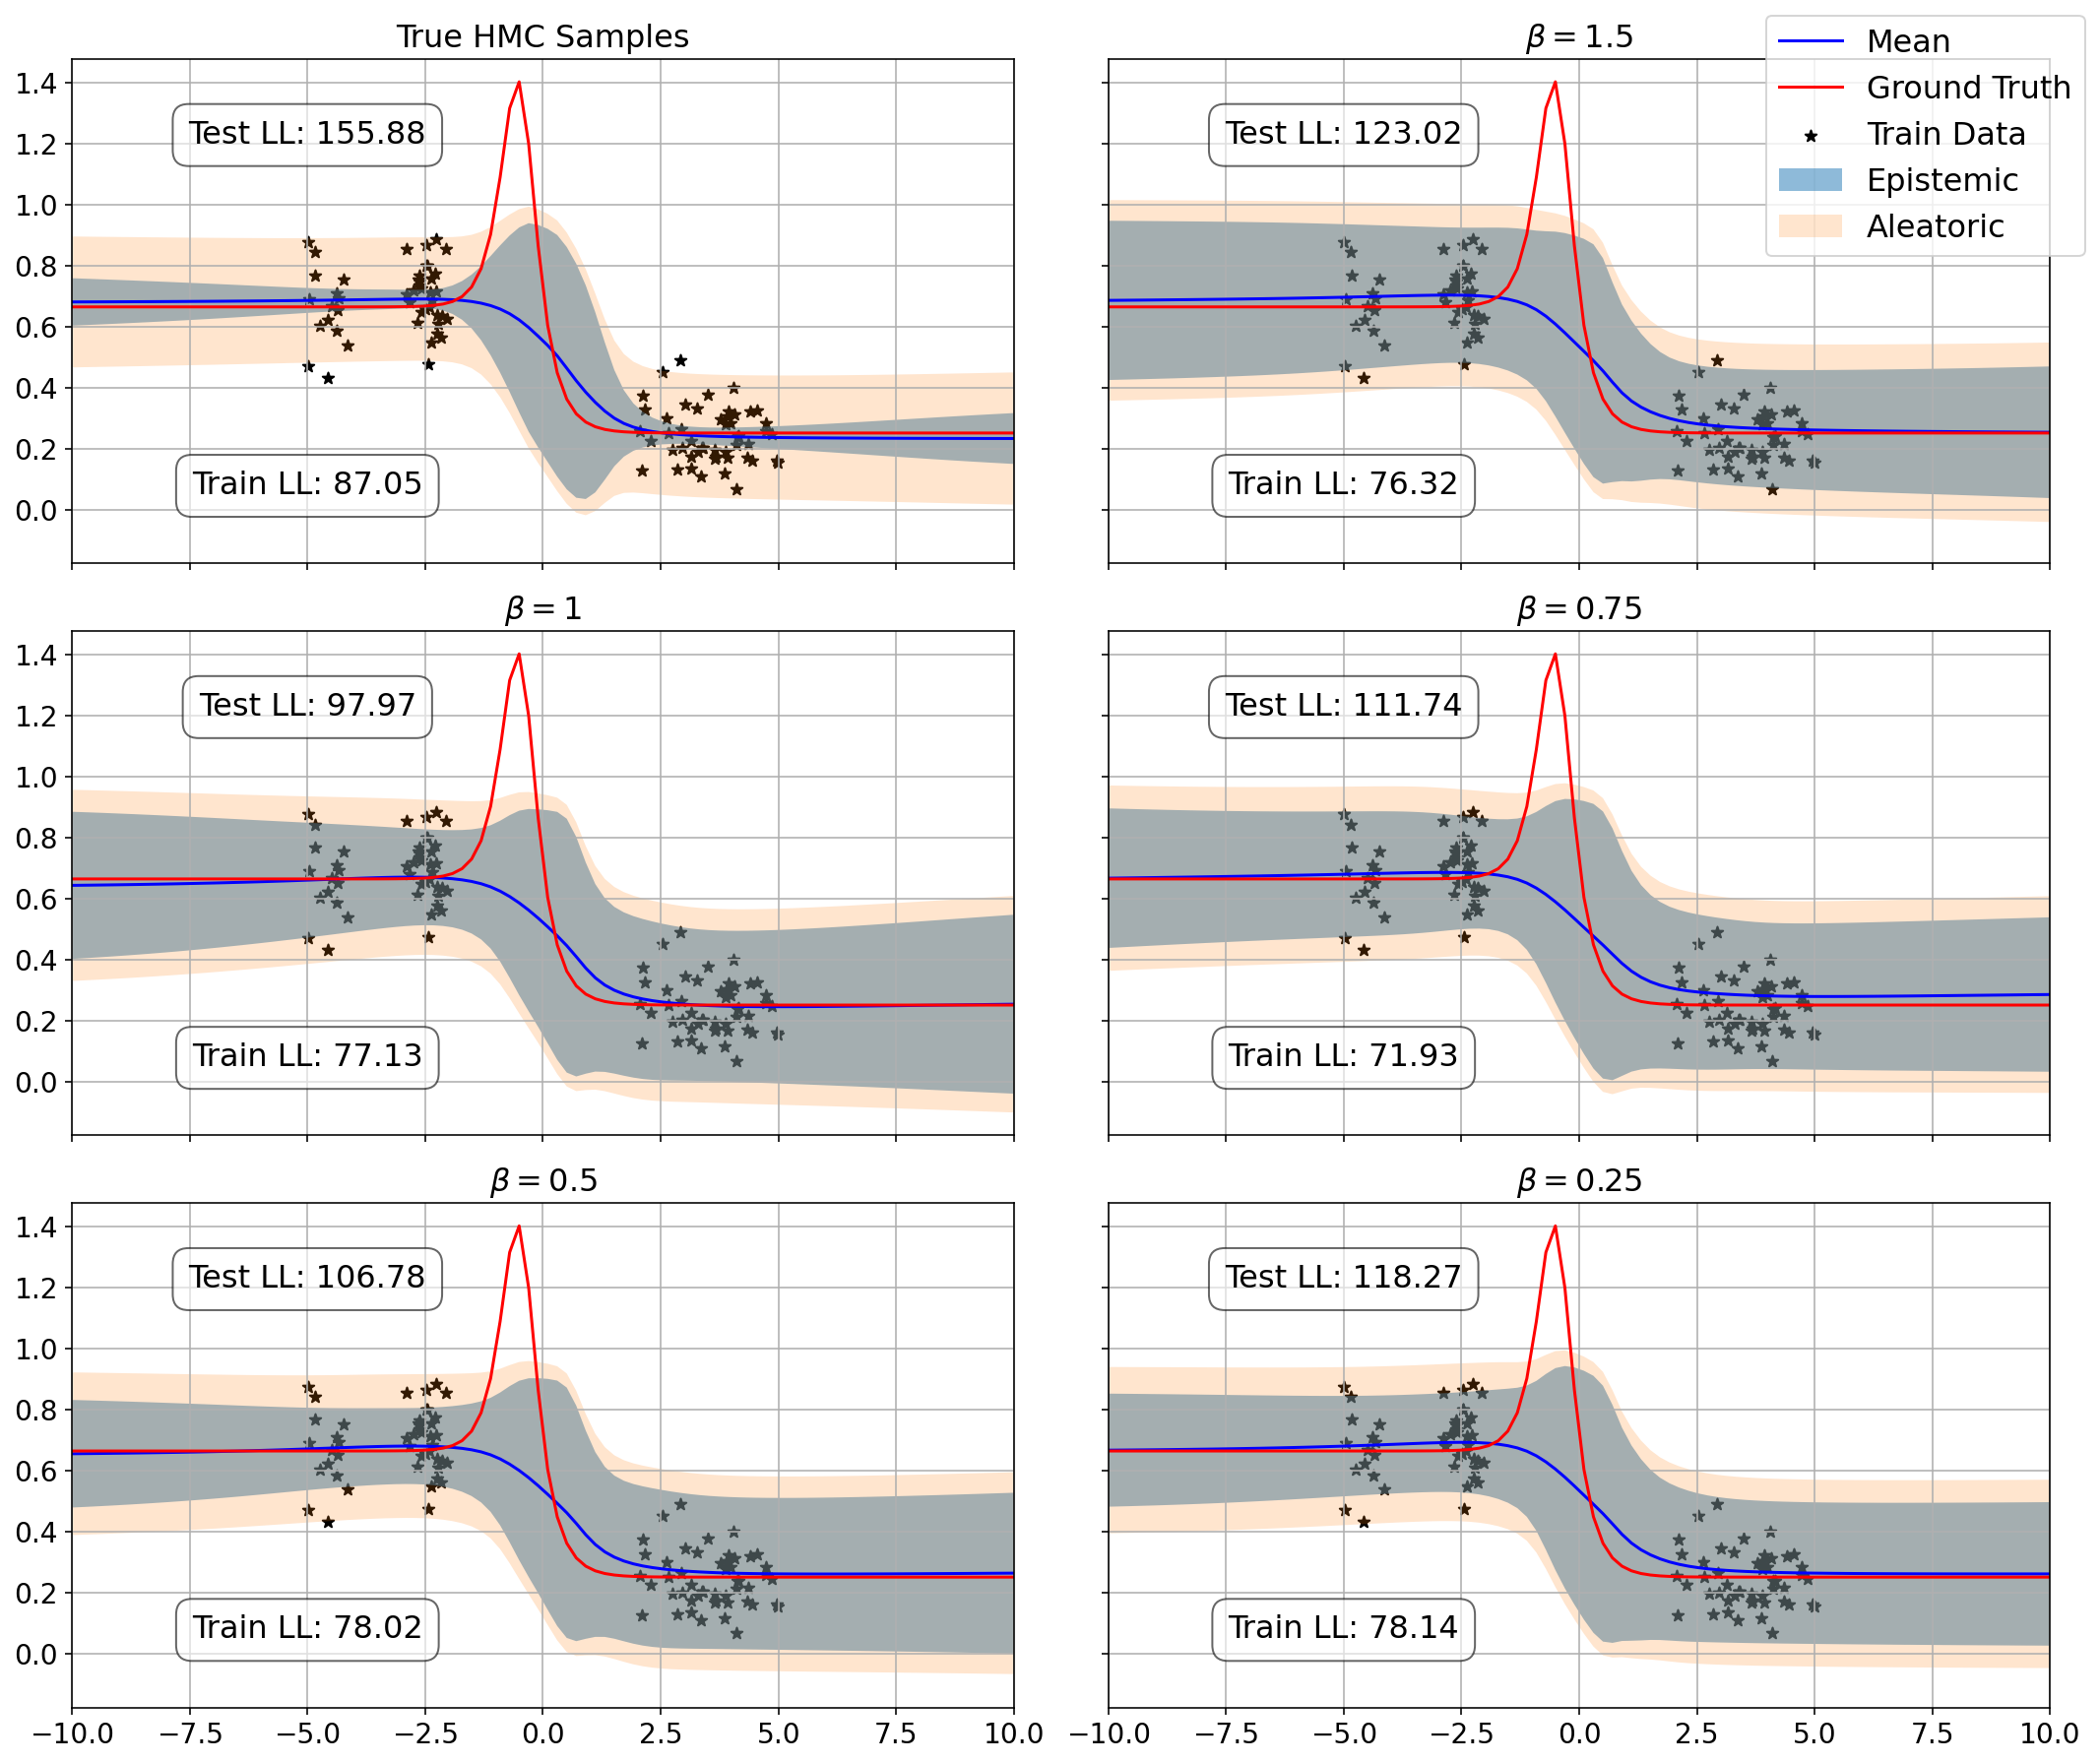

In [44]:
f, axes = plt.subplots(3, 2, figsize=(15, 12.5), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

## Epsilon = 0.1

In [45]:
# load data
compressed_weights_kde_beta_1_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1.5_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_beta_1 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_7_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.75_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.5_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_2_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.25_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_1 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.1_eps_0.1_1000.pkl', 'rb'))

In [46]:
weights = [true_hmc_weights, compressed_weights_kde_beta_1_5, compressed_weights_kde_beta_1, 
           compressed_weights_kde_beta_0_7_5, compressed_weights_kde_beta_0_5,
           compressed_weights_kde_beta_0_2_5, compressed_weights_kde_beta_0_1]

In [47]:
preds = {}
preds['True HMC Samples'] = true_hmc_weights
preds[r'$\beta = 1.5$'] = compressed_weights_kde_beta_1_5
preds[r'$\beta = 1$'] = compressed_weights_kde_beta_1
preds[r'$\beta = 0.75$'] = compressed_weights_kde_beta_0_7_5
preds[r'$\beta = 0.5$'] = compressed_weights_kde_beta_0_5
preds[r'$\beta = 0.25$'] = compressed_weights_kde_beta_0_2_5
preds[r'$\beta = 0.1$'] = compressed_weights_kde_beta_0_1

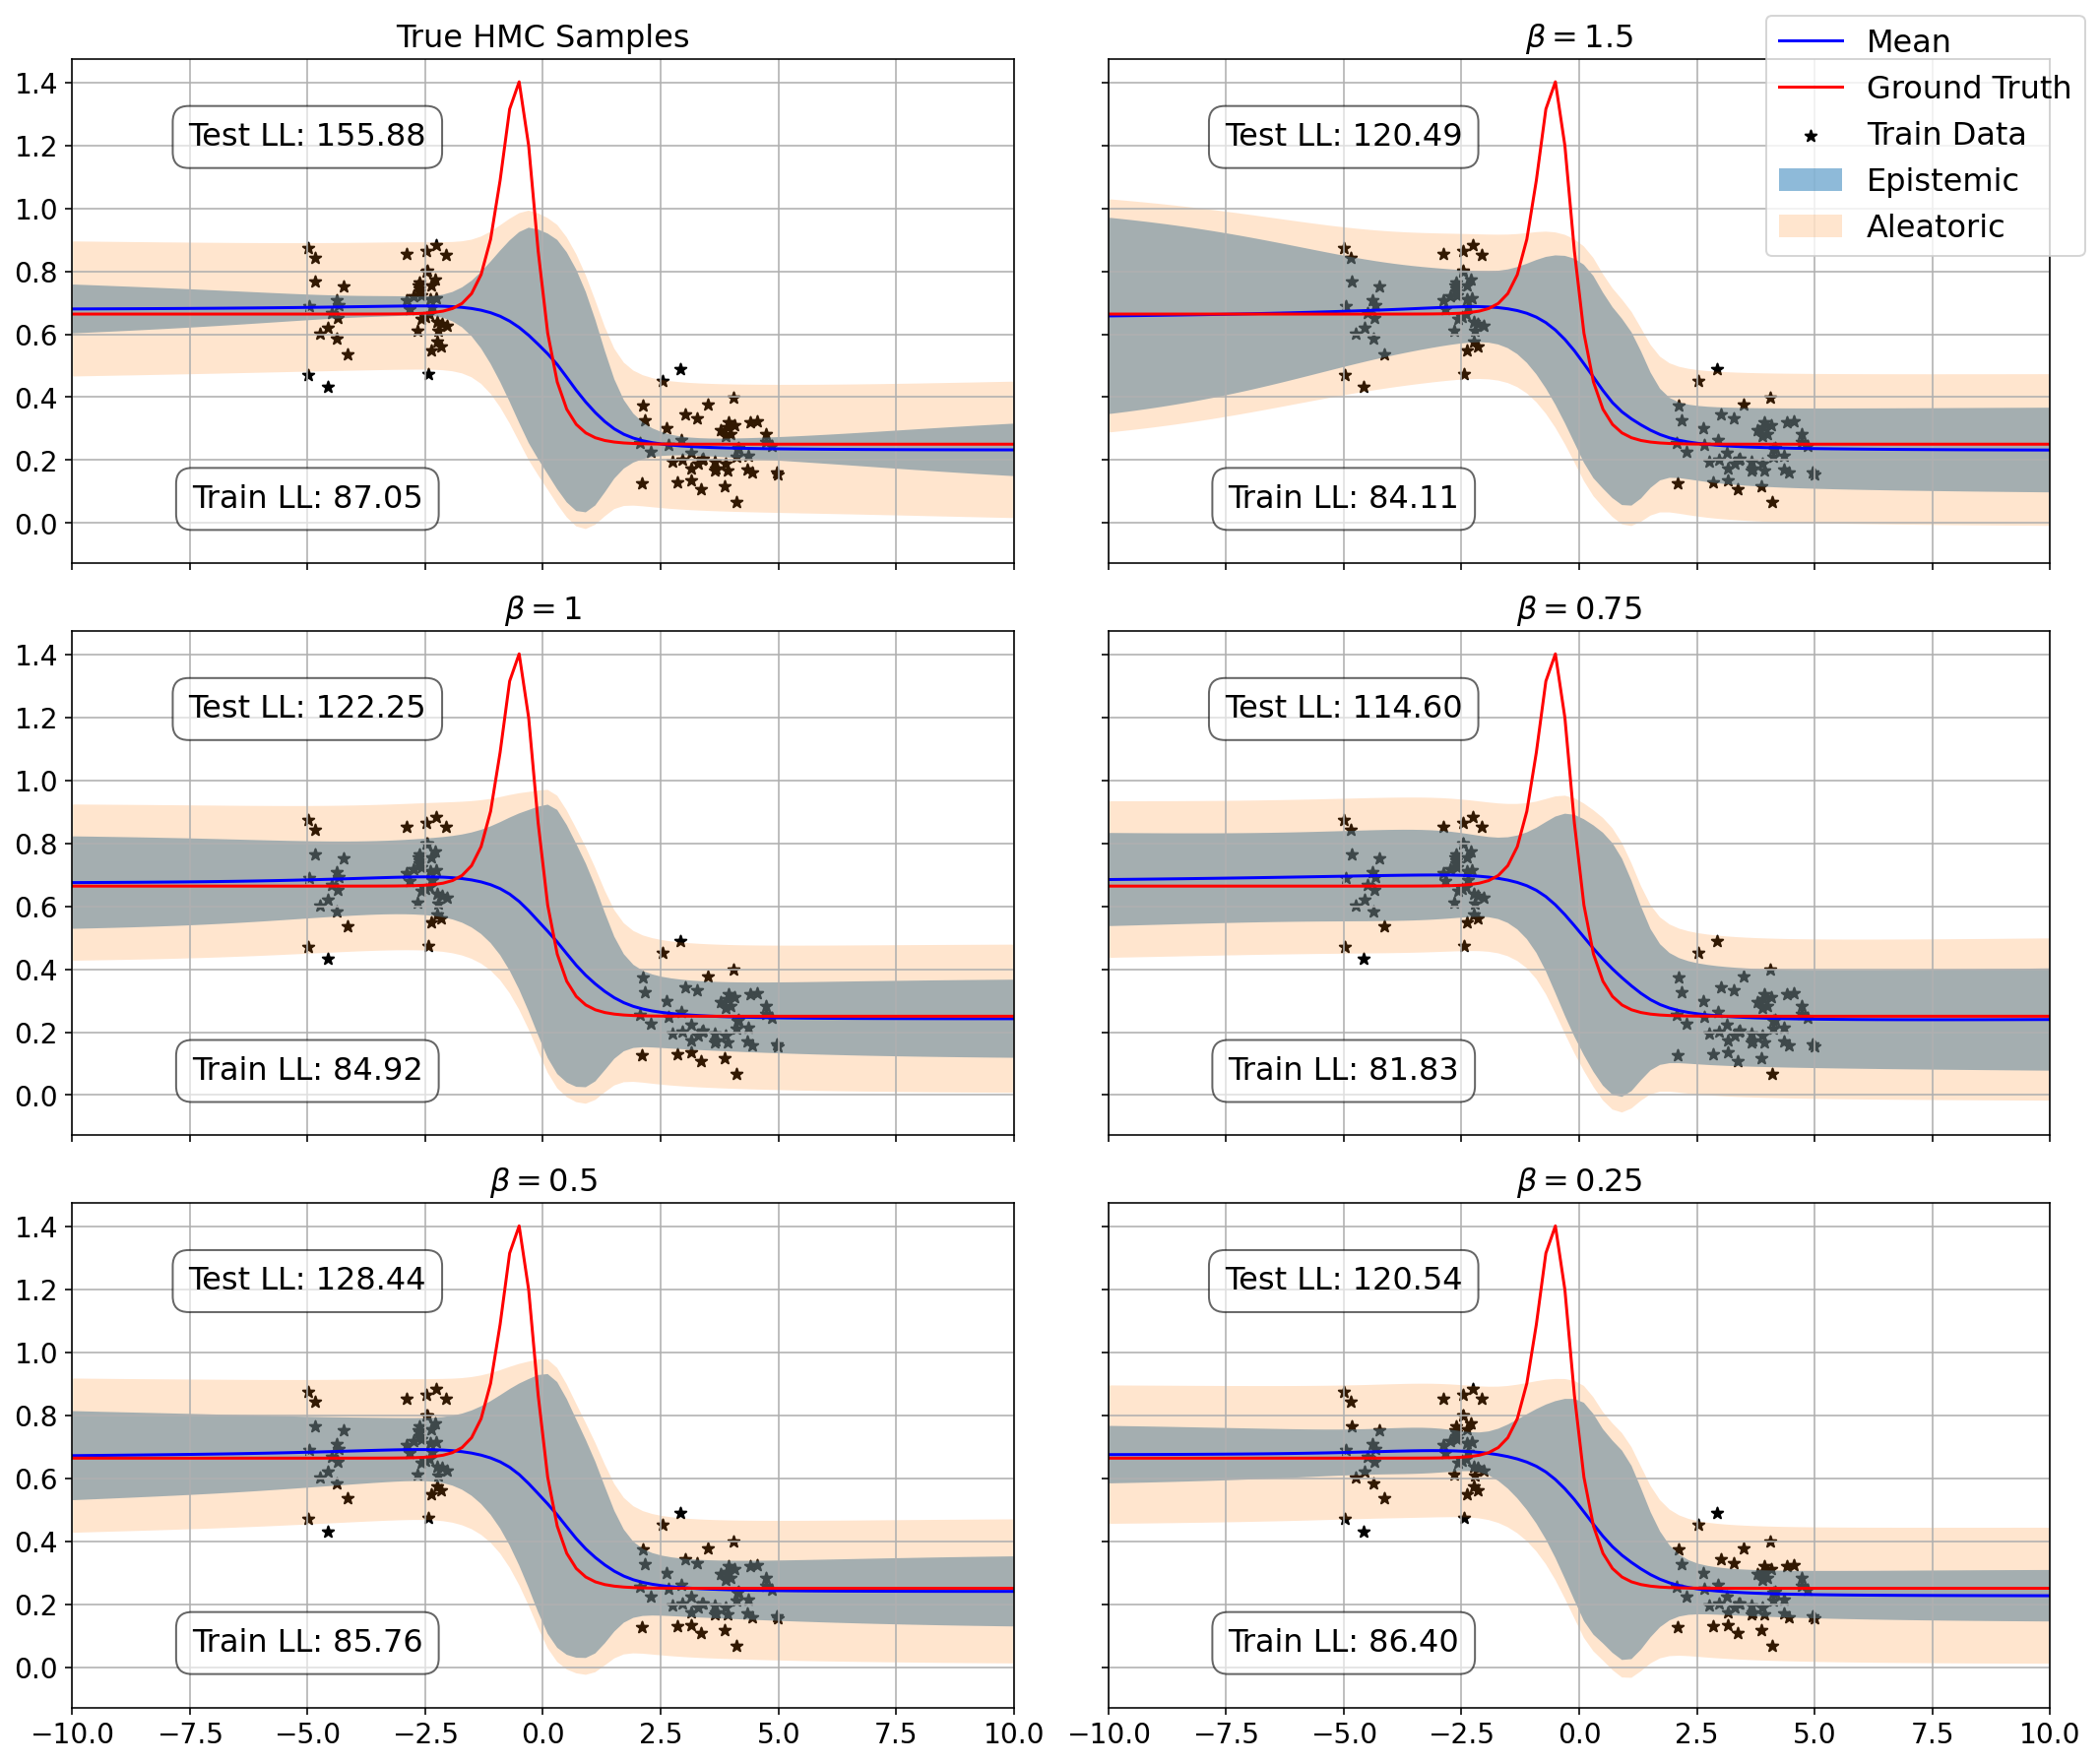

In [48]:
f, axes = plt.subplots(3, 2, figsize=(15, 12.5), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

## Epsilon = 0.2

In [49]:
# load data
compressed_weights_kde_beta_1_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1.5_eps_0.2_1000.pkl', 'rb'))
compressed_weights_kde_beta_1 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0.2_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_7_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.75_eps_0.2_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.5_eps_0.2_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_2_5 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.25_eps_0.2_1000.pkl', 'rb'))
compressed_weights_kde_beta_0_1 = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_0.1_eps_0.2_1000.pkl', 'rb'))

In [50]:
weights = [true_hmc_weights, compressed_weights_kde_beta_1_5, compressed_weights_kde_beta_1, 
           compressed_weights_kde_beta_0_7_5, compressed_weights_kde_beta_0_5,
           compressed_weights_kde_beta_0_2_5, compressed_weights_kde_beta_0_1]

In [51]:
preds = {}
preds['True HMC Samples'] = true_hmc_weights
preds[r'$\beta = 1.5$'] = compressed_weights_kde_beta_1_5
preds[r'$\beta = 1$'] = compressed_weights_kde_beta_1
preds[r'$\beta = 0.75$'] = compressed_weights_kde_beta_0_7_5
preds[r'$\beta = 0.5$'] = compressed_weights_kde_beta_0_5
preds[r'$\beta = 0.25$'] = compressed_weights_kde_beta_0_2_5
preds[r'$\beta = 0.1$'] = compressed_weights_kde_beta_0_1

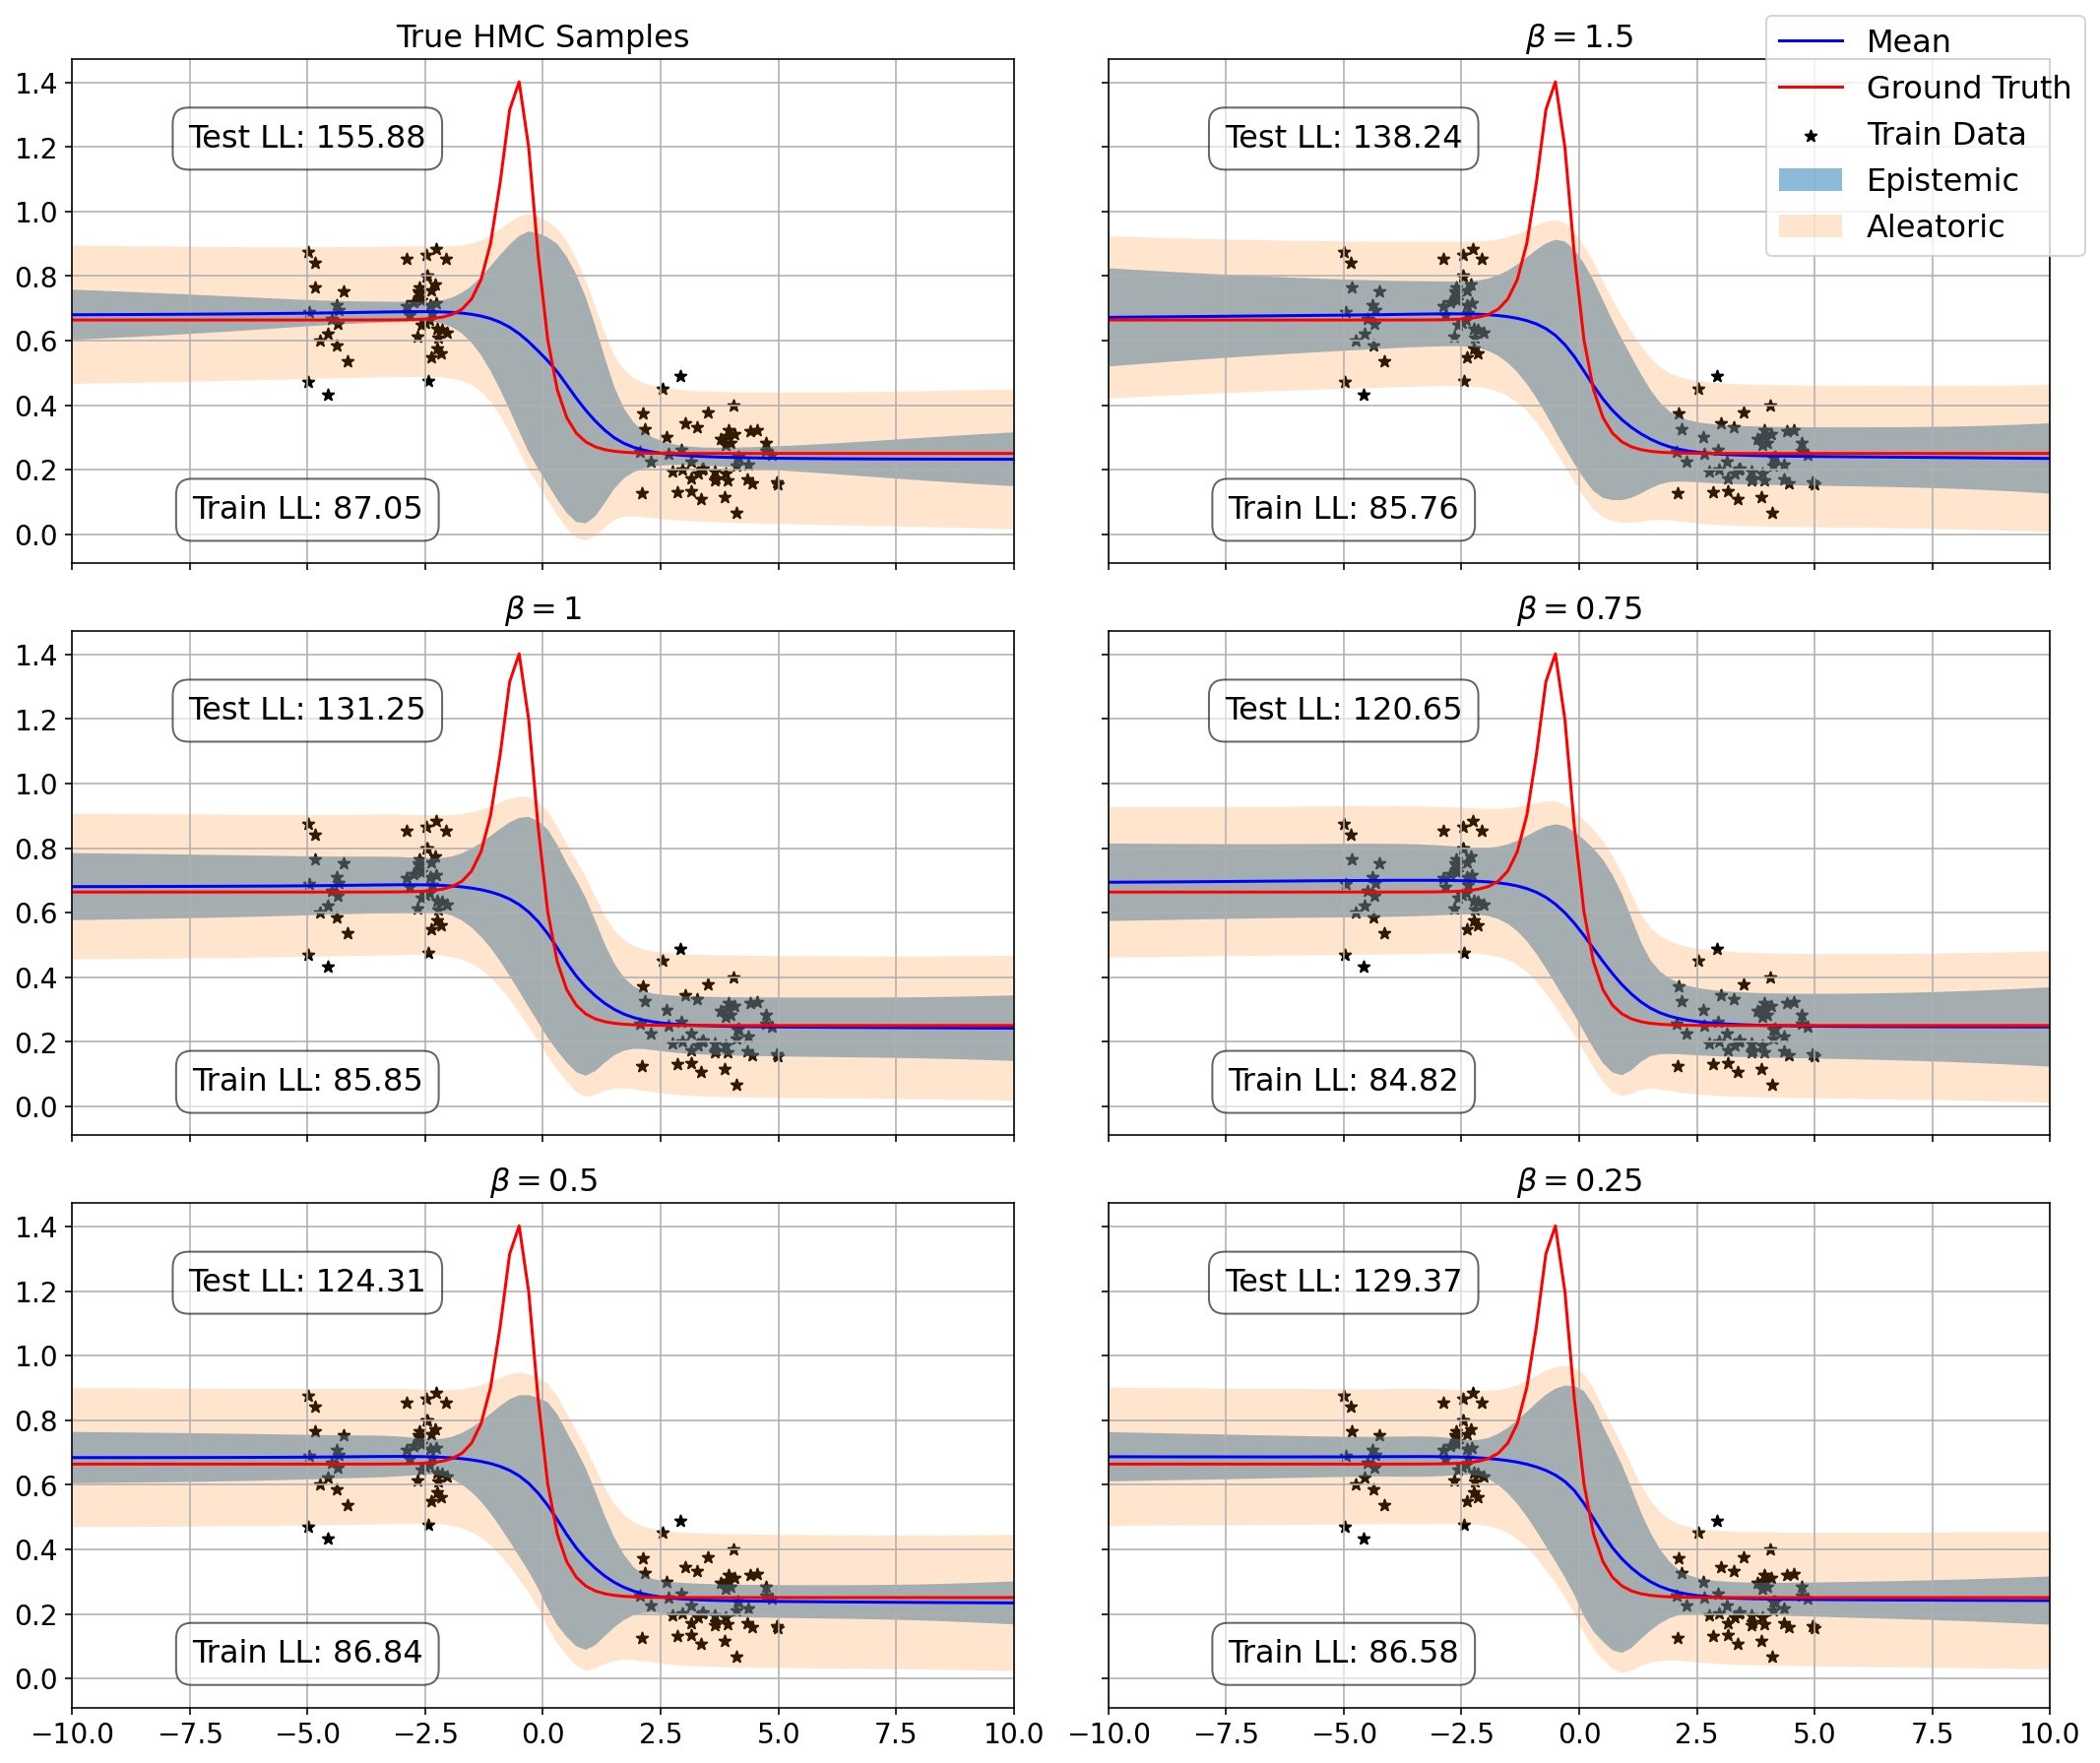

In [52]:
f, axes = plt.subplots(3, 2, figsize=(15, 12.5), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()

# Emp vs KDE vs Variational

In [53]:
# load data
true_hmc_weights = pkl.load(open('PickledStuff/BNN_STUFF/HMC_TRUE_WEIGHTS.pkl', 'rb'))
compressed_weights_kde_exact = pkl.load(open('PickledStuff/BNN_STUFF/kde_exact_beta_1_1000.pkl', 'rb'))
compressed_weights_kde_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0_1000.pkl', 'rb'))
compressed_weights_kde_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0.1_1000.pkl', 'rb'))
compressed_weights_kde_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/kde_beta_1_eps_0.2_1000.pkl', 'rb'))
compressed_weights_emp_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/emp_0_1000.pkl', 'rb'))
compressed_weights_emp_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/emp_0.1_1000.pkl', 'rb'))
compressed_weights_emp_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/emp_0.2_1000.pkl', 'rb'))
compressed_weights_var_exact = pkl.load(open('PickledStuff/BNN_STUFF/var_exact_beta_1.pkl', 'rb'))
compressed_weights_var_low_eps = pkl.load(open('PickledStuff/BNN_STUFF/var_beta_1_eps_0.pkl', 'rb'))
compressed_weights_var_med_eps = pkl.load(open('PickledStuff/BNN_STUFF/var_beta_1_eps_0.1.pkl', 'rb'))
compressed_weights_var_high_eps = pkl.load(open('PickledStuff/BNN_STUFF/var_beta_1_eps_0.2.pkl', 'rb'))

In [54]:
weights = [true_hmc_weights, compressed_weights_kde_exact, compressed_weights_var_exact,
           compressed_weights_kde_low_eps, compressed_weights_emp_low_eps, compressed_weights_var_low_eps,
           compressed_weights_kde_med_eps, compressed_weights_emp_med_eps, compressed_weights_var_med_eps,
           compressed_weights_kde_high_eps, compressed_weights_emp_high_eps, compressed_weights_var_high_eps,
          ]

In [55]:
preds = {}
preds['True HMC samples'] = true_hmc_weights
preds['Exact KDE Samples'] = compressed_weights_kde_exact
preds['Exact VAR Samples'] = compressed_weights_var_exact
preds['Compressed EMP, ' + r'$\epsilon=0$'] = compressed_weights_emp_low_eps
preds['Compressed KDE, ' + r'$\epsilon=0$'] = compressed_weights_kde_low_eps
preds['Compressed Var, ' + r'$\epsilon=0$'] = compressed_weights_var_low_eps
preds['Compressed EMP, ' + r'$\epsilon=0.1$'] = compressed_weights_emp_med_eps
preds['Compressed KDE, ' + r'$\epsilon=0.1$'] = compressed_weights_kde_med_eps
preds['Compressed VAR, ' + r'$\epsilon=0.1$'] = compressed_weights_var_med_eps
preds['Compressed EMP, ' + r'$\epsilon=0.2$'] = compressed_weights_emp_high_eps
preds['Compressed KDE, ' + r'$\epsilon=0.2$'] = compressed_weights_kde_high_eps
preds['Compressed VAR, ' + r'$\epsilon=0.2$'] = compressed_weights_var_high_eps

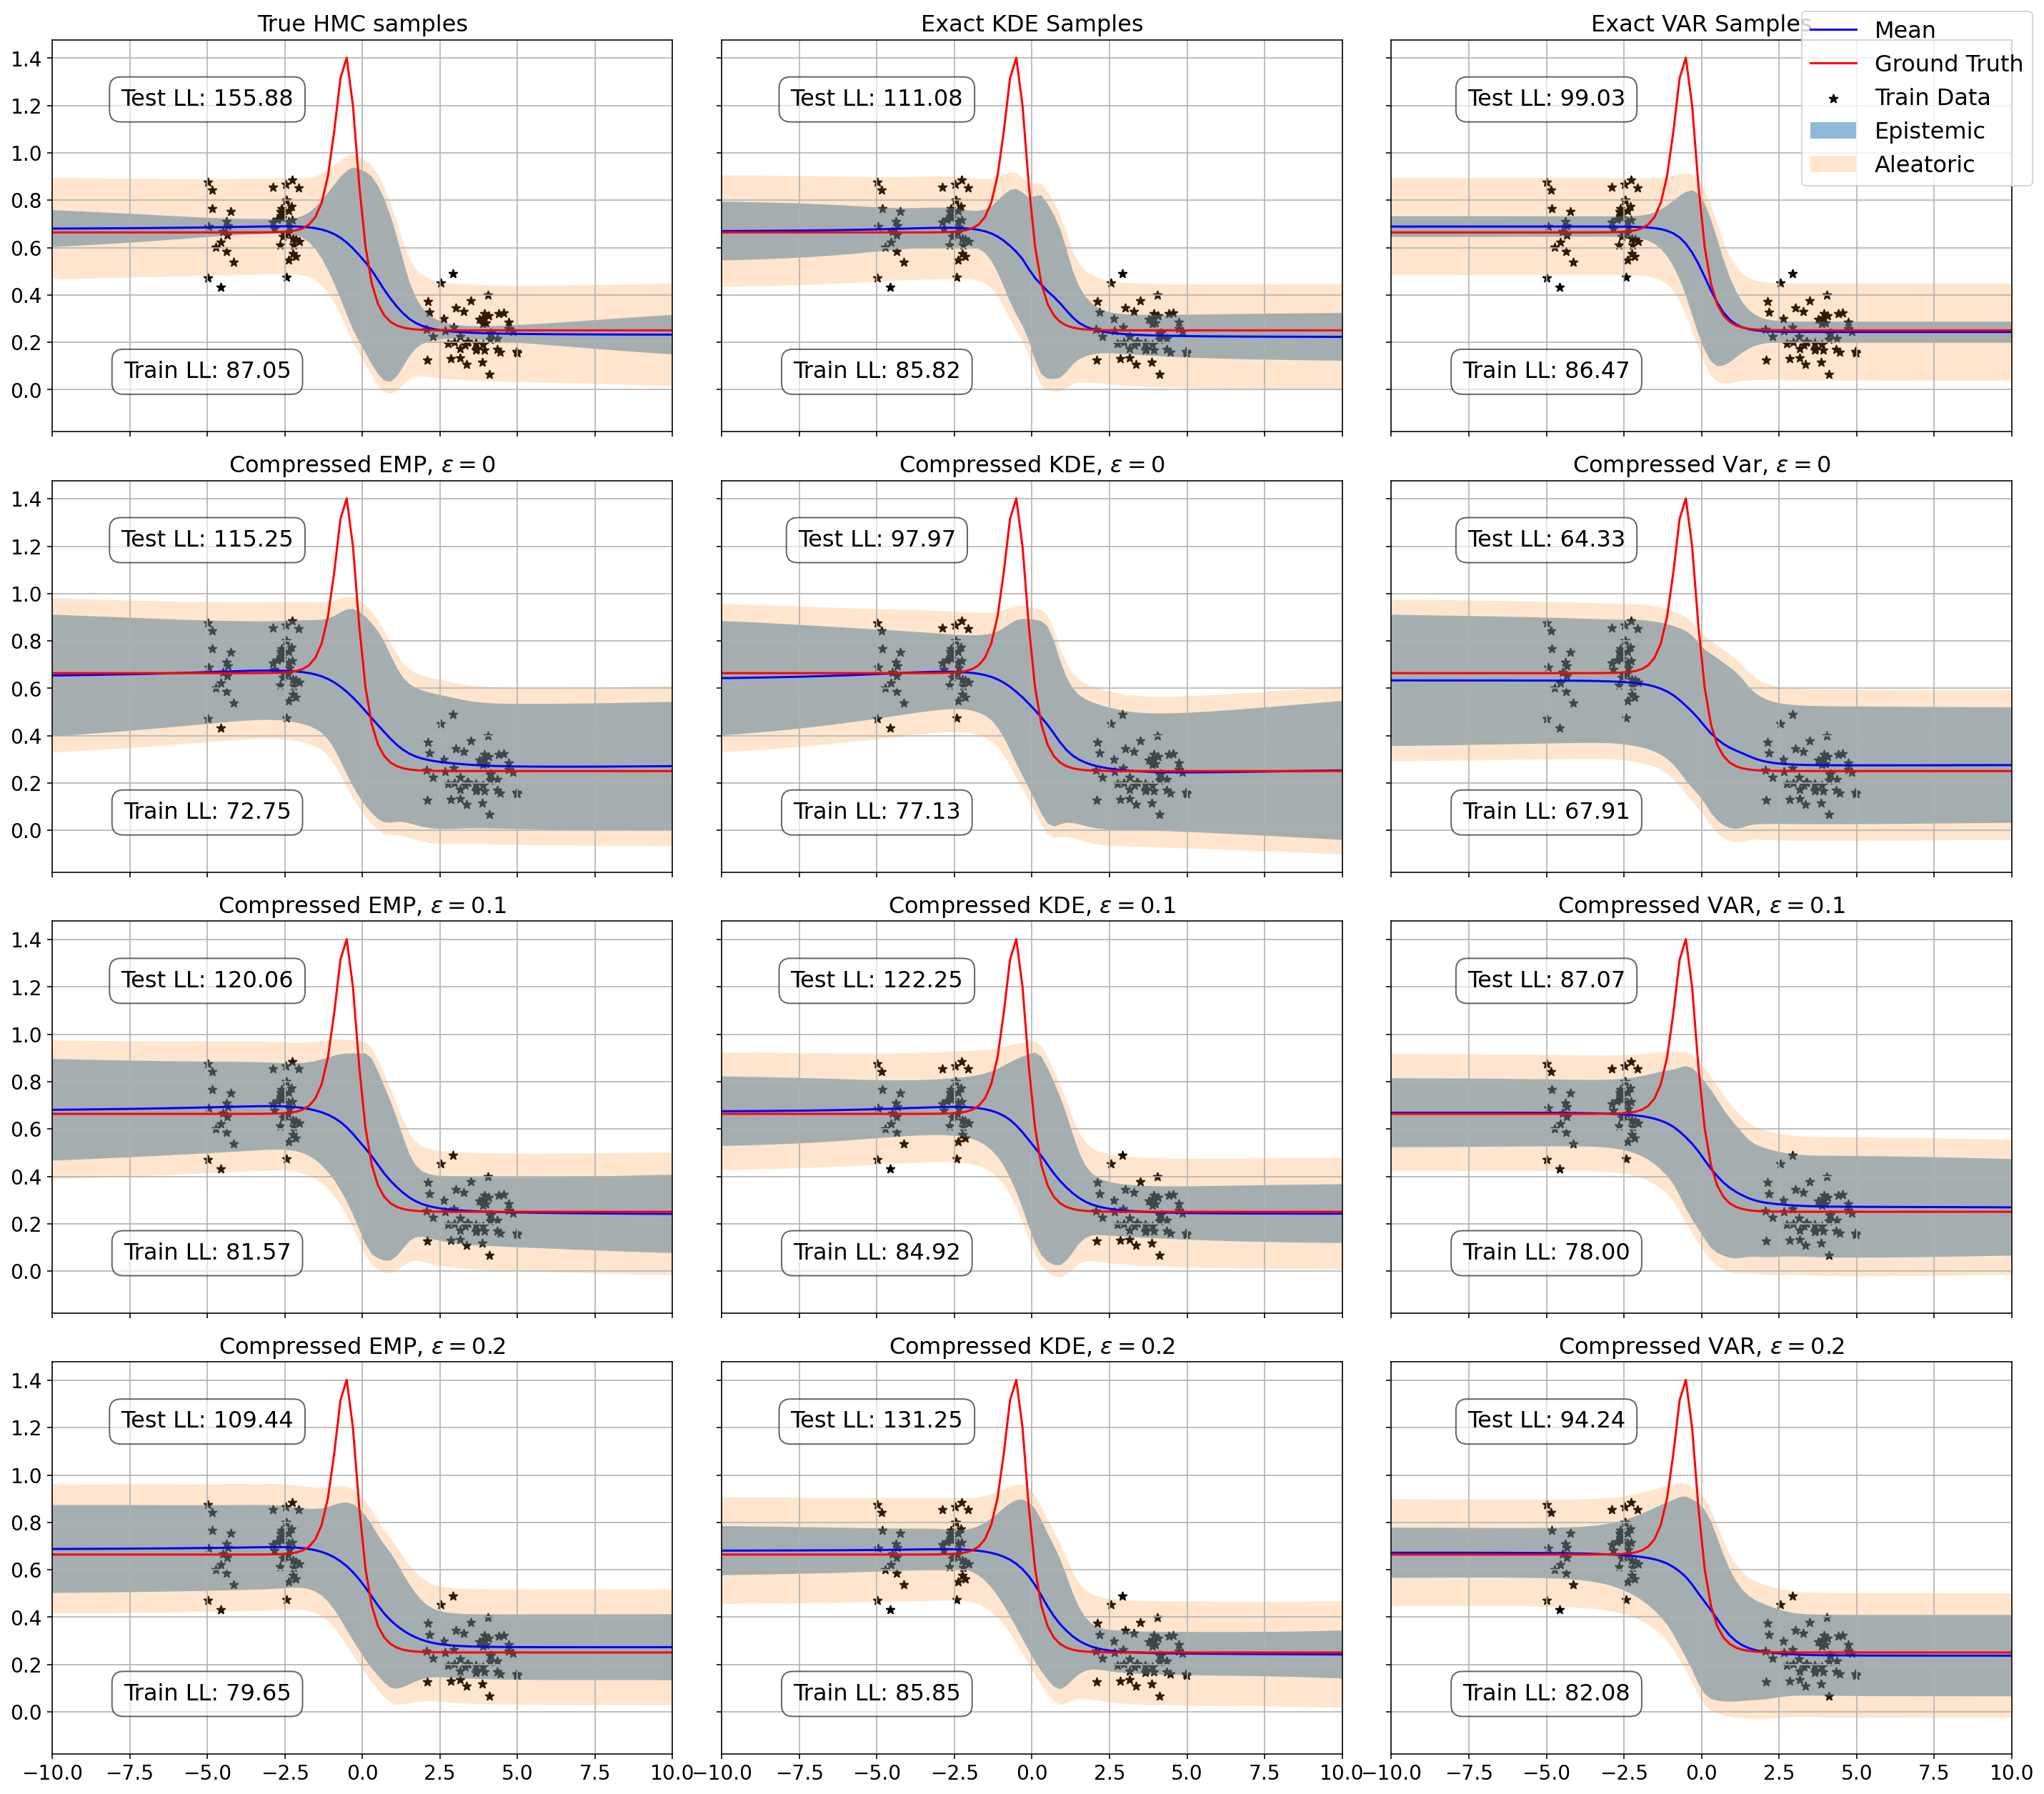

In [56]:
f, axes = plt.subplots(4, 3, figsize=(20, 17.5), sharex=True, sharey=True)
for pred, ax in zip(preds, axes.flatten()):
    plot_preds(preds[pred], ax, fs=16, title=pred)
    
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=16)
f.tight_layout()